# Portfolio Management Using Recurrent Neural Networks(RNNs)

*by Shamitha Gowra and Chaitanya Kurapati*

## 1. Introduction


We are fascinated by the power of deep learning to uncover complex patterns in sequential data. Specifically, we are interested in exploring recurrent neural networks like LSTMs for time series forecasting. By maintaining hidden state, RNNs can model non-linear temporal dynamics that are difficult to capture with traditional methods.

For this project, we have applied LSTMs to model stock price movements. Financial markets produce large volumes of structured, quantitative data perfectly suited for ML modeling. Markets exhibit complex dynamics including non-stationarity, non-linear relationships, regime changes - can benefit from advanced ML algorithms. Portfolio optimization is a well-defined problem but optimizing with real-world constraints is challenging. We think the ability to discover latent representations and dependencies could provide unique insights into market behavior. We are curious to analyze the internal workings of the trained RNN models to better understand what signals they extract from the noisy input data.

RNNs can learn long-term dependencies. RNNs have a memory state that allows them to learn from past inputs and use that information to make predictions about the future. This is important for portfolio management because asset prices are often influenced by long-term trends, such as economic growth and inflation.

We have also used multi-layer feedforward neural network model, that we have used for non linear regression in A3, to compare the results of LSTM predictions. This helped us gain insight into the difference that recurrent connections and memory cells make. We have included this in a separate notebook in the zip file.



In [1]:
!pip install pandas-datareader==0.10.0

In [2]:
import datetime
import pandas_datareader as pdr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

import random

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

## 2. Dataset

yfinance is a Python library that allows easy downloading of financial data from Yahoo Finance. It can download data for stocks, ETFs, mutual funds, currencies, cryptocurrencies, and more. Both US and international markets are supported. We have used it to download the stock price history of 5 different US companies, namely Apple, AMD(Advanced Micro Devices, Inc.), Intel Corporation, Microsoft and NVIDIA. We have selected these companies becasue they are all listed on NASDAQ making it easier to have a cohesive dataset. Moreover, they have all large, actively traded tech/hardware stocks. We have taken 5 years of historical data starting from 12/31/2017 to 12/31/2022. The term ticker refers to a unique series of letters assigned to a security for trading purposes. It is a shorthand symbol or code used to uniquely identify a particular publicly traded company's stock on a stock exchange.

In [3]:
tickers =['AAPL','AMD','INTC','MSFT','NVDA']

In [4]:
start_time = datetime.datetime(2017, 12, 31) # 2017-12-31
end_time = datetime.datetime(2022, 12, 31) # 2022-12-31

In [5]:
all_split = 1044

In [6]:
# Calculate the difference between end_time and start_time
time_difference = end_time - start_time

# Extract the number of days from the time difference
number_of_days = time_difference.days
print(f"Number of days between {start_time} and {end_time}: {number_of_days} days")

Number of days between 2017-12-31 00:00:00 and 2022-12-31 00:00:00: 1826 days


In [7]:
import yfinance as yf

In [8]:
# where to split training and validation datasets
all_split = 1044 # start 31/12/2009, val 02/01/2020, end 31/12/2021
# abbv_split = 1762 # start 02/01/2013
# fb_split = 1917 # start 18/05/2012
# tsla_split = 2394 # start 29/06/2010

We then download the stock price data for the first ticker in the tickers list (tickers[0]) from start_time to end_time using the yfinance API. It is then setting the index of the returned DataFrame (df) to be a DateTimeIndex using pandas so that it provides a more appropriate, time-aware index for stock price data.

In [9]:
# getting datetimeindex
df = yf.download(tickers[0], start_time, end_time)
df.index = pd.to_datetime(df.index)

[*********************100%%**********************]  1 of 1 completed


In [10]:
len(df)

1259

In [11]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [12]:
df.to_csv('/content/drive/My Drive/CS545 Project/yfData.csv', index=False)

In [13]:
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [14]:
# dataframe for Adj Close price
act_adj_close_df = pd.DataFrame(index=df.index, columns=tickers)
for ticker in tickers:
    stock_price_df = yf.download(ticker, start_time, end_time)
    stock_price_df.index = pd.to_datetime(stock_price_df.index)
    act_adj_close_df[ticker] = stock_price_df['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [15]:
act_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-02,40.722874,10.98,39.857128,80.229027,49.312790
2018-01-03,40.715786,11.55,38.504459,80.602386,52.558247
2018-01-04,40.904903,12.12,37.798351,81.311806,52.835316
2018-01-05,41.370613,11.88,38.062073,82.319908,53.283039
2018-01-08,41.216957,12.28,38.062073,82.403915,54.915668


In [16]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

## 3. Understanding the data distribution

__Line Graph:__

We started with a simple line graph to see how the stock prices fluctuated with time over the period of five years. We have only chose to do this for a random ticker because it allows us to get a general understanding of how the stock prices vary without focusing too much on how the trend varies for every stock. From the below graph we an see that the fluctuations are pretty high and we can see rough and jagged curves throughout the specified duration.

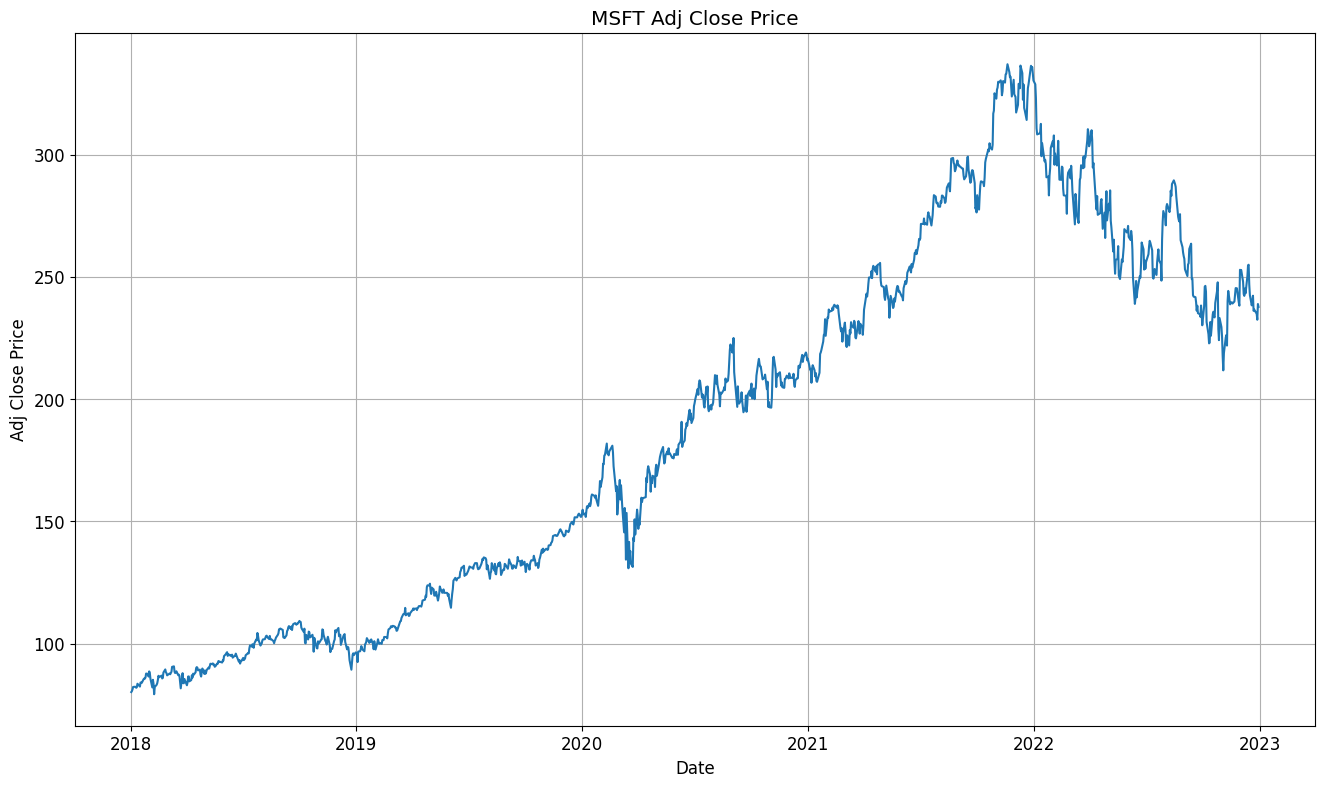

In [17]:
# plotting Adj Close price distribution of random ticker
rand_ticker = random.choice(tickers)
plt.plot(act_adj_close_df[rand_ticker].index, act_adj_close_df[rand_ticker])
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Adj Close Price')
plt.show()

__Using Histogram:__

Let's try plotting the data on a histogram. The histogram visually represents the distribution of adjusted closing prices for a particular stock (specified by rand_ticker). The x-axis represents the bins or intervals, the y-axis represents the count or frequency of data points in each bin, and the title provides information about the stock for which the histogram is generated. The histogram allowed us to observe the shape of the distribution and understand the concentration of prices within different ranges. Since the histogram is for adjusted closing prices of a stock, it means that within the dataset, there were 250 occurrences (or observations) where the adjusted closing price fell within the specified range of 30 to 105 for the randon ticker.

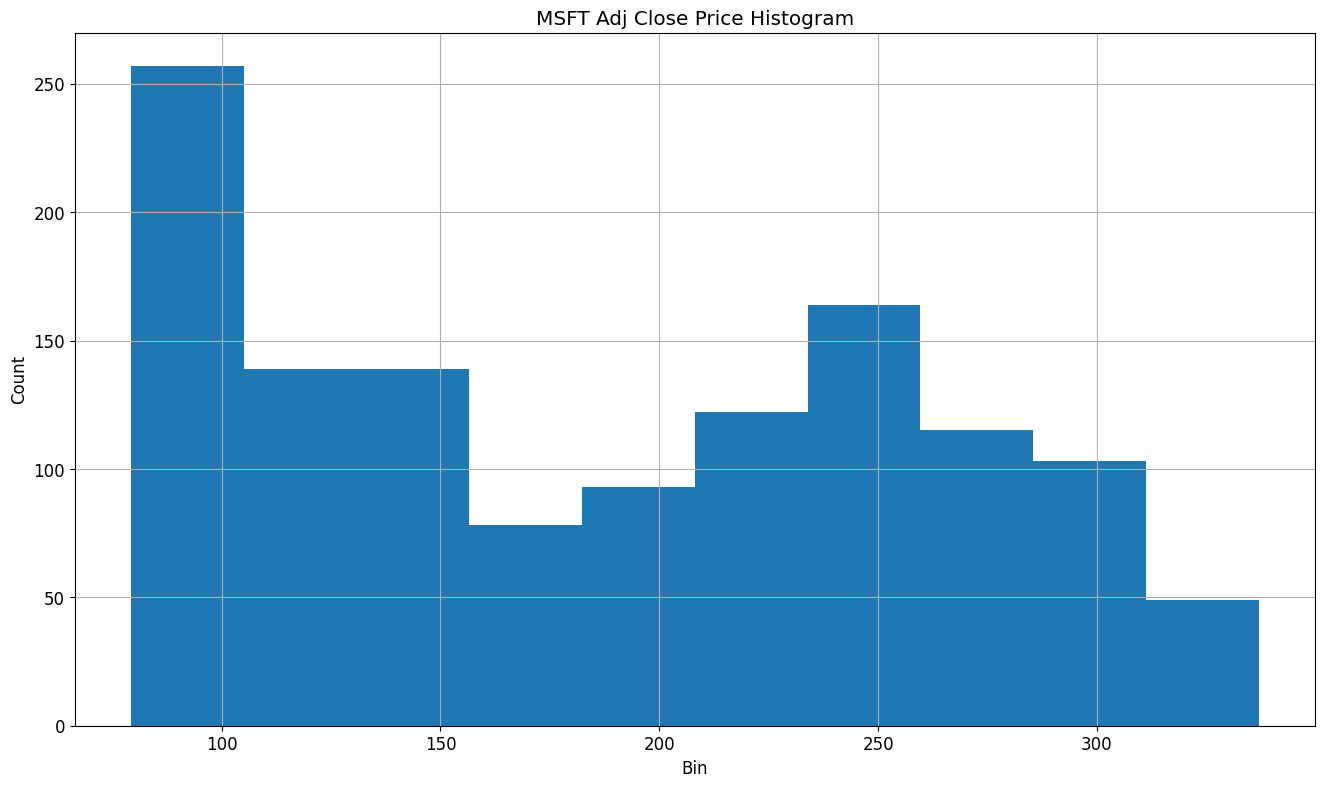

In [18]:
# histogram
plt.hist(act_adj_close_df[rand_ticker])
plt.xlabel('Bin')
plt.ylabel('Count')
plt.title(f'{rand_ticker} Adj Close Price Histogram')
plt.show()

__Q-Q plot:__

The Q-Q plot is a graphical tool used to assess if a dataset follows a particular theoretical distribution, in this case, comparing the distribution of adjusted closing prices for a specific stock (specified by rand_ticker) to a theoretical standard normal distribution. Patterns or deviations from the reference line (in this case, the standardized line) can provide insights into the distribution of the data. From the graph we can see that the data deviates from the standardized line towards the ends. In practical terms, this deviation from normality implies that extreme price movements (either high or low) are more common than what a normal distribution would predict.

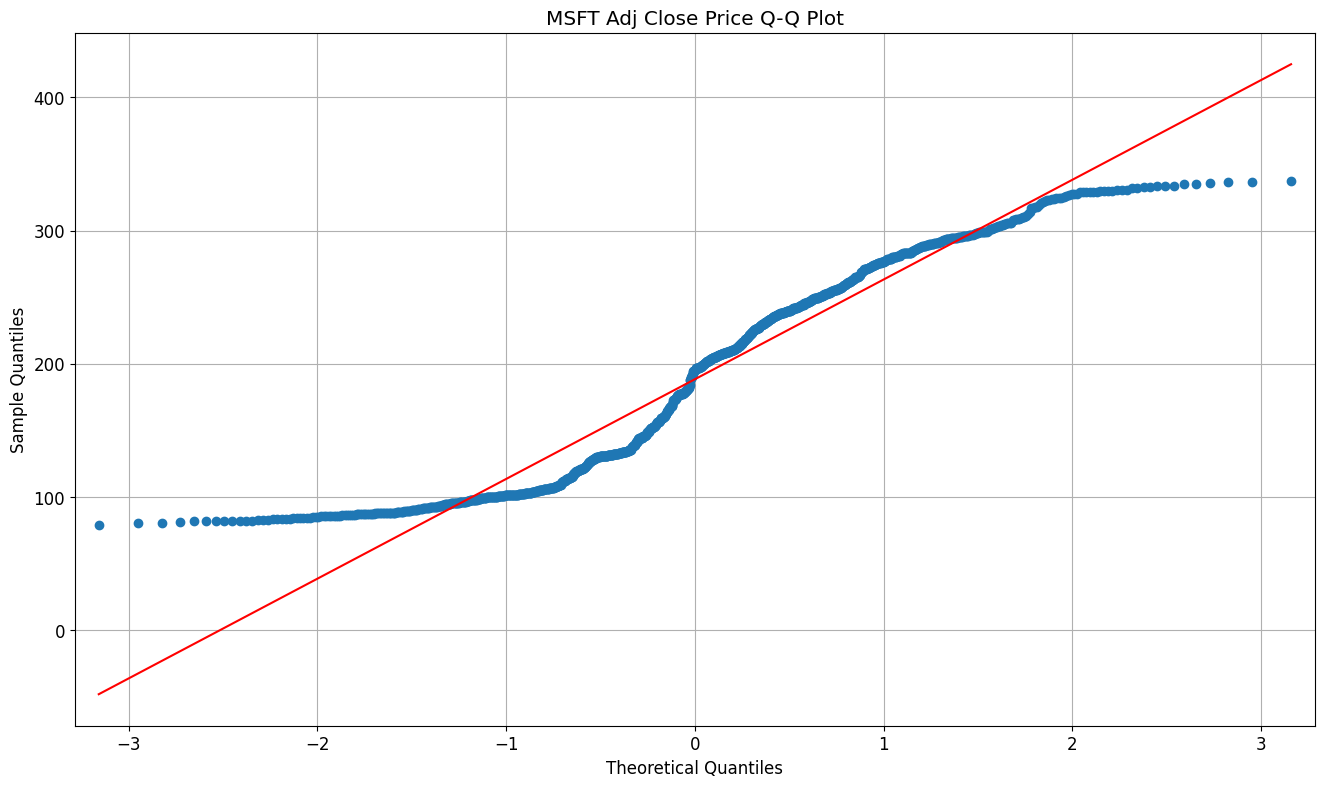

In [19]:
# q-q plot
qqplot(act_adj_close_df[rand_ticker], line='s')
plt.title(f'{rand_ticker} Adj Close Price Q-Q Plot')
plt.show()

In [20]:
act_adj_close_df.to_csv('act-adj-close-df.csv')

## 4. Building LSTM model

In [21]:
# selecting gpu
device = torch.device('cuda')

We have defined the LSTM_model class, which inherits from nn.Module, the base class for all neural network modules in PyTorch. This is a basic LSTM model that can be used for sequence-to-one prediction tasks, where the input is a sequence, and the model predicts a single output for each sequence. The __init__ method is the constructor of the class, where the architecture of the LSTM model is defined. The object self.lstm defines an LSTM layer using the parameters provided (input size, hidden size, number of layers). The argument batch_first=True indicates that the input data will have the batch size as the first dimension. We then defined a fully connected(linear) layer self.fc, mapping from the LSTM hidden state space to the output classes.

The forward method defines the forward pass of the model. The variables h0 and c0 represent the initial hidden and cell states respectively and are initialized with zeros. These are the initial states of the LSTM, and they are moved to the specified device (e.g., GPU). The input tensor x is passed through the LSTM layer, and the output (out) is obtained. The underscore _ indicates that the cell states are not being used here. The output of the last time step is extracted and passed through the fully connected layer (fc) to obtain the final output which is returned.

In [22]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # number of features
        self.hidden_size = hidden_size # number of features in hidden state
        self.num_layers = num_layers # number of stacked LSTM layers
        self.num_classes = num_classes # number of output classes

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0),
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0),
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

Then we proceeded to create the build_model function that is responsible for creating an LSTM model along with its optimizer and loss function. We have used the adam optimizer to optimize the model's parameters (weights) during training to minimize the loss. We have used MSE loss function which is commonly used for regression tasks and measures the average squared difference between predicted and actual values. The function returns the created LSTM model, the optimizer, and the loss function which are then used for training and evaluating the model.

In [23]:
# function for building model
def build_model(input_size=1, hidden_size=1, num_layers=1, num_classes=1, learning_rate=0.001):
    # learning rate controls how much to change model in response to estm error
    # each time model weights are updated

    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    return model, optimizer, loss_function

## 5. Model fitting and evaluation

When comparing models or applying cross-validation, it's important to have consistent scaling across different folds or datasets. Using a scaler ensures that the scaling is consistent. In this case, we have used the MinMaxScaler which scales features based on the minimum and maximum values in the dataset, transforming each feature to a range between 0 and 1.

In [24]:
# scaler for normalizing dataset
scaler = MinMaxScaler()

__Creation of X and y:__

We have defined a function create_xy to create input-output pairs for time series prediction. It takes a time series dataset (data) and a parameter (time_step) to determine the length of input sequences. The input sequences (X) are formed by taking consecutive subarrays of length time_step, and the corresponding output values (y) are the data points immediately following each input sequence, i.e. stock price for the next time step.

In [25]:
# function for creating X and y
def create_xy(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

We defined three different data frames to store various information related to a machine learning model trained on stock market data.

1. model_loss_df stores the loss values of the model during training.

2. pred_adj_close_df stores the predicted adjusted closing prices of the trained model.

3. model_perf_df stores performance metrics of the model, such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and Mean Percentage Error (MPE).

__Different Metrics for Performance Evaluation:__

Each function in the provided code computes a distinct performance metric by assessing the relationship between the true values (y_true) and the predicted values (y_hat).

_Mean Absolute Error (MAE):_ MAE quantifies the average absolute difference between the true and predicted values, offering insights into the typical magnitude of errors.

_Mean Squared Error (MSE):_ MSE calculates the average of the squared differences between the true and predicted values, assigning more weight to larger errors compared to MAE.

_Root Mean Squared Error (RMSE):_ RMSE is the square root of MSE, presenting a measure of the typical error magnitude in the same unit as the target variable.

_Mean Absolute Percentage Error (MAPE):_ MAPE gauges the average percentage difference between the true and predicted values, providing a relative measure of accuracy.

_Mean Percentage Error (MPE):_ MPE, akin to MAPE, considers the average percentage difference but without taking the absolute value. It can be positive or negative, signifying overestimation or underestimation.

In [28]:
# functions for model performance evaluation
def MAE(y_true, y_hat):
    return np.mean(np.abs(y_true - y_hat))

def MSE(y_true, y_hat):
    return np.mean(np.square(y_true - y_hat))

def RMSE(y_true, y_hat):
    return np.sqrt(MSE(y_true, y_hat))

def MAPE(y_true, y_hat):
    return np.mean(np.abs((y_true - y_hat) / y_true)) * 100

def MPE(y_true, y_hat):
    return np.mean((y_true - y_hat) / y_true) * 100

The below function, 'fit_model' is created for training a PyTorch-based LSTM model for a given stock. It initializes an LSTM model, an optimizer (Adam optimizer), and a mean-squared error loss function using the build_model function. It checks whether a GPU is available. If available, the model and training data are moved to the GPU; otherwise, they remain on the CPU. The function then executes a training loop for a specified number of epochs. In each epoch, it performs a forward pass, computes the loss using mean-squared error, and executes a backward pass to compute gradients. The model parameters are updated using the optimizer. The training loss for every 1000 epochs is logged and stored in the model_loss_df DataFrame. The function saves the state of the trained model to a file using torch.save. The file is named based on the stock's ticker symbol and is stored in a specified directory. The trained model is then returned so that it can used for evaluation.

In [29]:
import torch

def fit_model(ticker, X_train, y_train, input_size=1, hidden_size=1, num_layers=1, num_classes=1, num_epochs=10000, learning_rate=0.001):
    # Create model, optimizer, and loss function with specified parameters
    model, optimizer, loss_function = build_model(input_size, hidden_size, num_layers, num_classes, learning_rate)

    #num_epochs = 10000  # Number of training epochs
    loss_list = []  # List to store training losses during each epoch

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if GPU is available

    model.to(device)  # Move the model to the appropriate device
    X_train, y_train = X_train.to(device), y_train.to(device)  # Move training data to the device

    for epoch in range(num_epochs + 1):
        outputs = model(X_train)  # Forward pass
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation
        loss = loss_function(outputs, y_train)  # Calculate the loss
        loss.backward()  # Backward pass to compute gradients
        optimizer.step()  # Update the model parameters

        if epoch % 1000 == 0:
            loss_list.append(loss.item())  # Append the current loss to the list

    model_loss_df[ticker] = loss_list  # Store the training losses in the dictionary

    # Saving model state
    torch.save(model.state_dict(), f'/content/drive/My Drive/CS545 Project/{ticker}-model-state.pth')

    return model  # Return the trained model


Run_experiment function is defined so that we can change the parameters and perform various experiments on the data to get the best possible model. We use the previously defined scalar function to normalize the adjusted close values. We then use the variable all_split to split the data into training and validation sets. To train the model, we use create_xy function to get input-output pairs (X_train, y_train) and (X_val, y_val). Using the Variable and torch.Tensor functions, we covert the above mentioned datasets to PyTorch tensors. The fit_model function trains an LSTM model for the current stock using the specified input parameters (n_input, n_hidden, n_layers, n_classes, nepochs, lr). These are the parameters that we will experiment on. In the next step, we predict the response (y_hat) for the validation set using the trained model. The predictions are converted back to the original scale by applying an inverse transformation using the same scaler. The perfromance predictors are calculated and stored in a dataframe for further analysis.

In [31]:
def run_experiment(n_input, n_hidden, n_layers, n_classes, nepochs, lr):
    for ticker in tickers:
    # normalizing dataset
      norm_act_adj_close = scaler.fit_transform(np.array(act_adj_close_df[ticker]).reshape(-1, 1), )

      train_set, val_set = norm_act_adj_close[:all_split], norm_act_adj_close[all_split:]

      X_train, y_train = create_xy(train_set, time_step)
      X_val, y_val = create_xy(norm_act_adj_close, time_step)

    # converting datasets to tensors
      X_train_tensors = Variable(torch.Tensor(X_train))
      y_train_tensors = Variable(torch.Tensor(y_train))

      X_val_tensors = Variable(torch.Tensor(X_val))
      y_true = scaler.inverse_transform(y_val) # inverse transformation

    # fitting model
      print('----------')
      print(f'{ticker} fitting...')
      print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')
      model = fit_model(ticker=ticker, X_train=X_train_tensors, y_train=y_train_tensors, input_size=n_input, hidden_size=n_hidden, num_layers=n_layers, num_classes=n_classes, num_epochs = nepochs, learning_rate=lr)

    # predicting response
      y_hat = model(X_val_tensors.to(device)) # forward pass
      y_hat = y_hat.data.detach().cpu().numpy() # numpy conversion
      y_hat = scaler.inverse_transform(y_hat) # inverse transformation
      print('Done!')

      pred_adj_close_df[ticker] = y_hat

      model_perf_df[ticker] = [MAE(y_true, y_hat), MSE(y_true, y_hat), RMSE(y_true, y_hat),
                             MAPE(y_true, y_hat), MPE(y_true, y_hat)]




## 6. Results

## 6.1 With Three-day Time Step:

Initially, we started with a three day step where we take the value of stock price from three days prior the given date to calculate the target value.

We have started with a very simple and basic version of LSTM with a single hidden unit in the one LSTM layer. Since predicting stock prices is a regression task, the value of n_classes is set to 1. 

In [26]:
time_step = 3

In [27]:
# dataframes for model loss, predicted Adj Close price and model performance
model_loss_df = pd.DataFrame(index=[epoch for epoch in range(0, 11000, 1000)], columns=tickers)
pred_adj_close_df = pd.DataFrame(index=df.index[time_step + 1:], columns=tickers)
model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'], columns=tickers)

In [32]:
import time
start = time.time()
run_experiment(n_input = 1, n_hidden = 1, n_layers = 1, n_classes = 1, nepochs = 10000, lr = 0.001)
Time = (time.time() - start) / 60/ 60
print("Time Elapsed: " , Time)

----------
AAPL fitting...
4 left
Done!
----------
AMD fitting...
3 left
Done!
----------
INTC fitting...
2 left
Done!
----------
MSFT fitting...
1 left
Done!
----------
NVDA fitting...
0 left
Done!
Time Elapsed:  0.027022875481181673


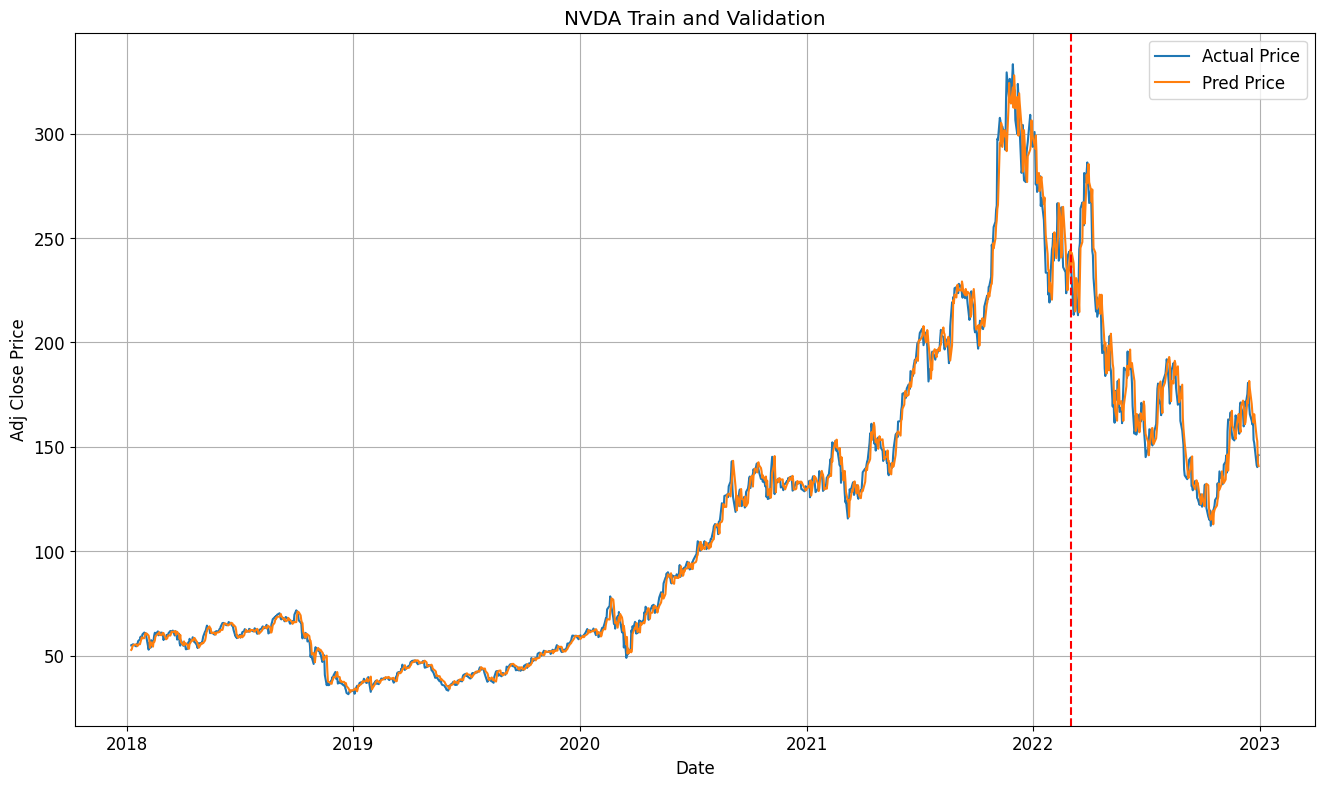

In [33]:
# plotting actual and predicted Adj Close price of random ticker
rand_ticker = random.choice(tickers)
plt.plot(pred_adj_close_df.index, act_adj_close_df[rand_ticker][time_step + 1:], label='Actual Price')
plt.plot(pred_adj_close_df.index, pred_adj_close_df[rand_ticker], label='Pred Price')
plt.axvline(x=pred_adj_close_df.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Train and Validation')
plt.legend()
plt.show()

From the above graph, we can see that the predicted price closely follows the actual price. Let's zoom into the validation predictions to see if we can see fluctuations.

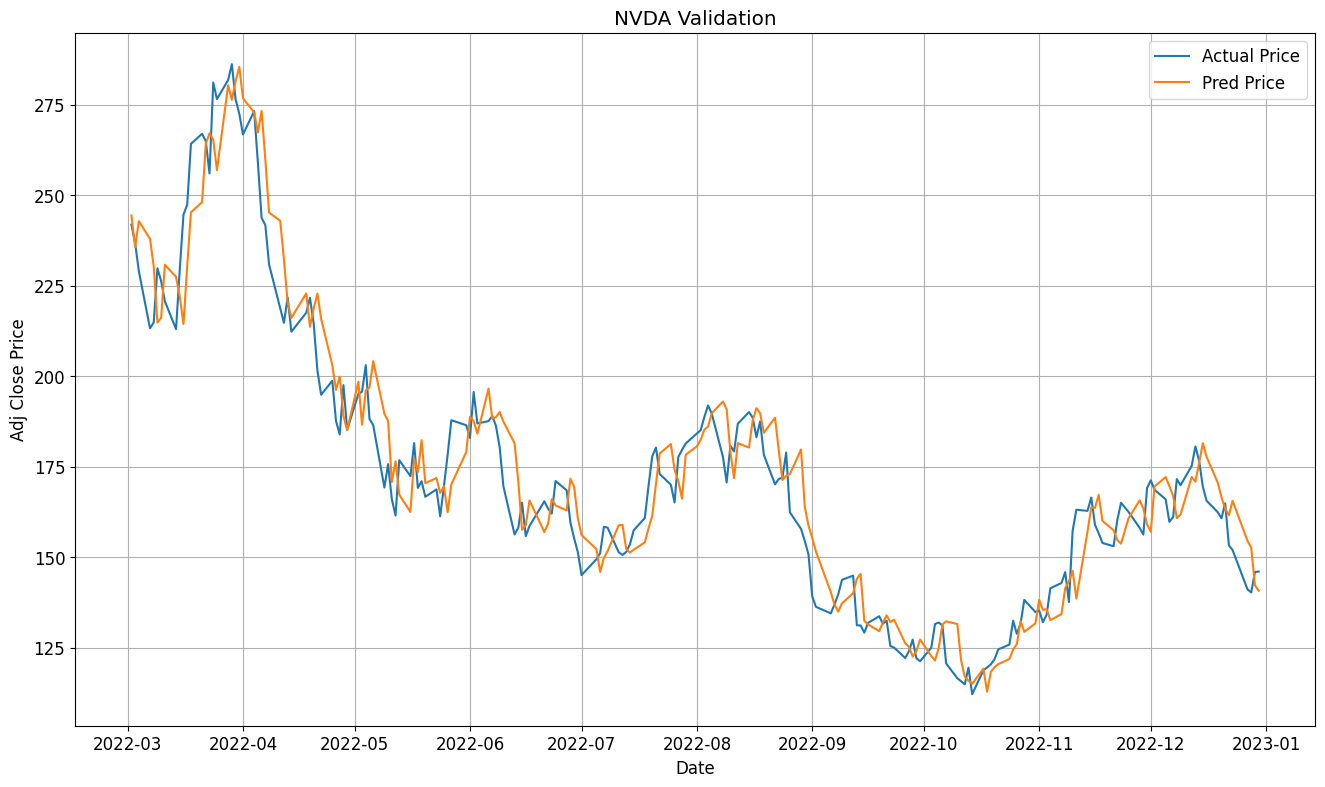

In [34]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]

plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()

Here we can see that the validate set's prediction values are fluctuating from the actual prices quite a bit. The Val RMSE value also seems to be higher around 104.36

In [35]:
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')

Val RMSE: 104.36723202651574


In [36]:
model_loss_df.tail()

,AAPL,AMD,INTC,MSFT,NVDA
6000,0.000309,0.000290,0.001053,0.000387,0.000229
7000,0.000263,0.000230,0.000879,0.000338,0.000202
8000,0.000216,0.000203,0.000812,0.000281,0.000183
9000,0.000181,0.000201,0.000810,0.000231,0.000175
10000,0.000165,0.000201,0.000808,0.000195,0.000172


This is last five rows of the model loss DataFrame. Each row represents loss for the stocks AAPL, AMD, INTC, MSFT, and NVDA at different epochs. The values represent the loss calculated by a model, which is typically a measure of how well or poorly the model is performing on its predictions. From the decreasing trend in the loss values across iterations for all the companies, it can be inferred that the model is improving over time in predicting or fitting the data for these specific stocks. 

In [37]:
pred_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-08,41.268902,12.258846,38.487507,84.528885,52.750065
2018-01-09,41.641907,12.123867,38.432899,85.300514,53.200935
2018-01-10,41.615643,12.443954,38.450024,85.517159,54.586426
2018-01-11,41.604736,12.093806,37.908215,85.520859,54.850288
2018-01-12,41.590900,12.165926,37.188850,85.269920,55.215775


In [38]:
act_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-02,40.722874,10.98,39.857128,80.229027,49.312790
2018-01-03,40.715786,11.55,38.504459,80.602386,52.558247
2018-01-04,40.904903,12.12,37.798351,81.311806,52.835316
2018-01-05,41.370613,11.88,38.062073,82.319908,53.283039
2018-01-08,41.216957,12.28,38.062073,82.403915,54.915668


From the above two cells, we can see that the predicted values are very close to the actual values. This suggests that the simple LSTM model also did a good job in predicting the stock prices reasonably. 

In [39]:
model_perf_df

,AAPL,AMD,INTC,MSFT,NVDA
MAE,1.512693,1.564761,0.991684,3.081458,2.906315
MSE,4.949283,5.841065,2.428464,18.049240,22.207691
RMSE,2.224698,2.416830,1.558353,4.248440,4.712504
MAPE,1.568134,2.620785,2.609802,1.677697,2.398317
MPE,-0.126260,-0.191637,-1.253993,-0.259107,-0.258055


Over all, from the model performance metrics, we can see that the RMSE values obtained for each stock are with in 10% of the actual values which can be considered a reasonably good prediction. 

The LSTM model for the INTC asset produced the lowest error and most precise return predictions. It had the smallest Mean Squared Error, Mean Absolute Error, and Root Mean Squared Error. This indicates the INTC model makes the most accurate forecasts with minimal variability in the errors. However, the model does have a tendency to systematically underestimate the actual returns.

On the other end, LSTM model for MSFT performed the worst in terms of predictive accuracy. It had high error rates across all metrics—highest MSE, MAE, RMSE and MAPE. So forecasts from the MSFT model are the least reliable with large variability in estimate errors. Its predictions tend to deviate widely from observed returns.

Interestingly, while the NVDA model did not have the outright lowest errors, it did have the smallest Mean Absolute Percentage Error. So its return forecasts were the most accurate in percentage terms relative to actual returns. Even if some error, the NVDA model’s predictions tend to be proportionally closest to realized returns.

Let's try if we can improve the performace of prediction by adding more hidden units.

In [40]:
model_loss_df.to_csv('model-loss-df.csv')
pred_adj_close_df.to_csv('pred-adj-close-df.csv')
model_perf_df.to_csv('model-perf-df.csv')

### Adding hidden units:

In [42]:
start = time.time()
run_experiment(n_input = 1, n_hidden = 10, n_layers = 1, n_classes = 1, nepochs = 10000, lr = 0.001)
Time = (time.time() - start) / 60/ 60
print("Time Elapsed: " , Time)

----------
AAPL fitting...
4 left
Done!
----------
AMD fitting...
3 left
Done!
----------
INTC fitting...
2 left
Done!
----------
MSFT fitting...
1 left
Done!
----------
NVDA fitting...
0 left
Done!
Time Elapsed:  0.02594256103038788


Val RMSE: 22.21939671985249


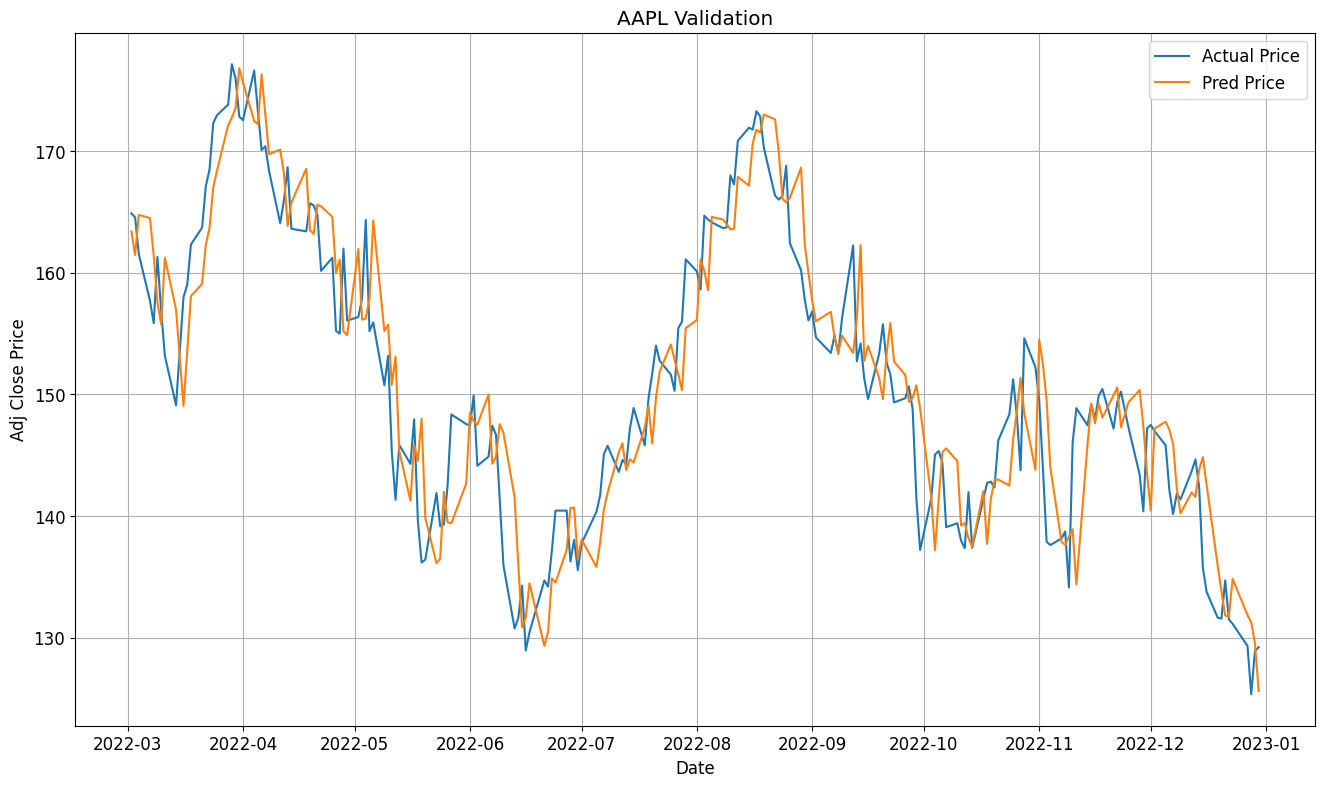

In [44]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')
plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()


The validation error has gone down notably from 104.36 to 22.22 which indicates that the model is learning better with the increased hidden layers. It also indicates that the model is better at generalizing patterns and relationships in the data to unseen examples.

In [45]:
model_loss_df.tail()

,AAPL,AMD,INTC,MSFT,NVDA
6000,0.000203,0.000201,0.000804,0.000178,0.000184
7000,0.000179,0.000200,0.000803,0.000158,0.000175
8000,0.000160,0.000199,0.000802,0.000151,0.000172
9000,0.000156,0.000199,0.000802,0.000151,0.000171
10000,0.000155,0.000199,0.000801,0.000151,0.000170


There is a notable difference in the loss values from the previous experiment. The loss values have decreased significantly upon addition of hidden units. Previously the loss value at 6000 epochs for AAPL was around 0.000309 and the value now is 0.000203. The final loss value for previous eperiment for AAPL stock is 0.000165 and for this run it is 0.000155, which even though might seem very negligible, given that the time elapsed for this experiment is lower than the previous one, it can be considered an easy win.

In [46]:
pred_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-08,40.914562,12.113913,38.176838,81.240761,53.016071
2018-01-09,41.305672,12.022768,38.233192,82.089912,53.367287
2018-01-10,41.305149,12.258231,38.322445,82.523048,54.895069
2018-01-11,41.272011,11.992995,37.639191,82.623978,55.072224
2018-01-12,41.261600,11.973356,36.732822,82.396103,55.417187


In [47]:
model_perf_df

,AAPL,AMD,INTC,MSFT,NVDA
MAE,1.453649,1.554094,0.814908,2.577750,2.891919
MSE,4.754654,5.788327,1.388737,14.347241,22.076466
RMSE,2.180517,2.405894,1.178447,3.787775,4.698560
MAPE,1.491655,2.583952,1.972120,1.354756,2.371653
MPE,-0.058686,-0.201106,-0.616309,-0.120959,-0.236072


There appears to be some improved predictive performance across several assets, due to the increase in hidden units.

The error levels (MAE, MSE, RMSE) have decreased noticeably for the INTC, MSFT and NVDA models, indicating their updated return predictions have become more precise and accurate overall. However, INTC still maintains the lowest errors so its forecasts remain the most reliable.

Interestingly, while some models improved accuracy in absolute terms (lower errors), their percentage-based metrics worsened somewhat. Both INTC and NVDA now have higher Mean Absolute Percentage Errors. So while these updated models make better absolute forecasts, proportional accuracy relative to realized returns deteriorated modestly. Their return ratios are off by a wider margin in percentage deviation terms.

Of the group, the updated model for AMD changed the least. With similar errors and slight deterioration in both absolute and percentage accuracy, its performance seems largely unaffected. The metrics imply only marginal differences in new AMD model predictive capabilities.

In summary, this change seems to have bolstered several LSTM models in terms of reduced forecast errors, but proportional inaccuracies have simultaneously increased somewhat for models like INTC and NVDA. Tradeoffs between absolute and relative predictive capabilities seem evident for assets with improved MSE, MAE and RMSE metrics after retraining models.

Let's try further increasing the number of hidden units to see if we can improve the perfromace of the models.

### Using more hidden units:

In [48]:
start = time.time()
run_experiment(n_input = 1, n_hidden = 50, n_layers = 1, n_classes = 1, nepochs = 10000, lr = 0.001)
Time = (time.time() - start) / 60/ 60
print("Time Elapsed: " , Time)

----------
AAPL fitting...
4 left
Done!
----------
AMD fitting...
3 left
Done!
----------
INTC fitting...
2 left
Done!
----------
MSFT fitting...
1 left
Done!
----------
NVDA fitting...
0 left
Done!
Time Elapsed:  0.0274413483010398


Val RMSE: 20.879679262759336


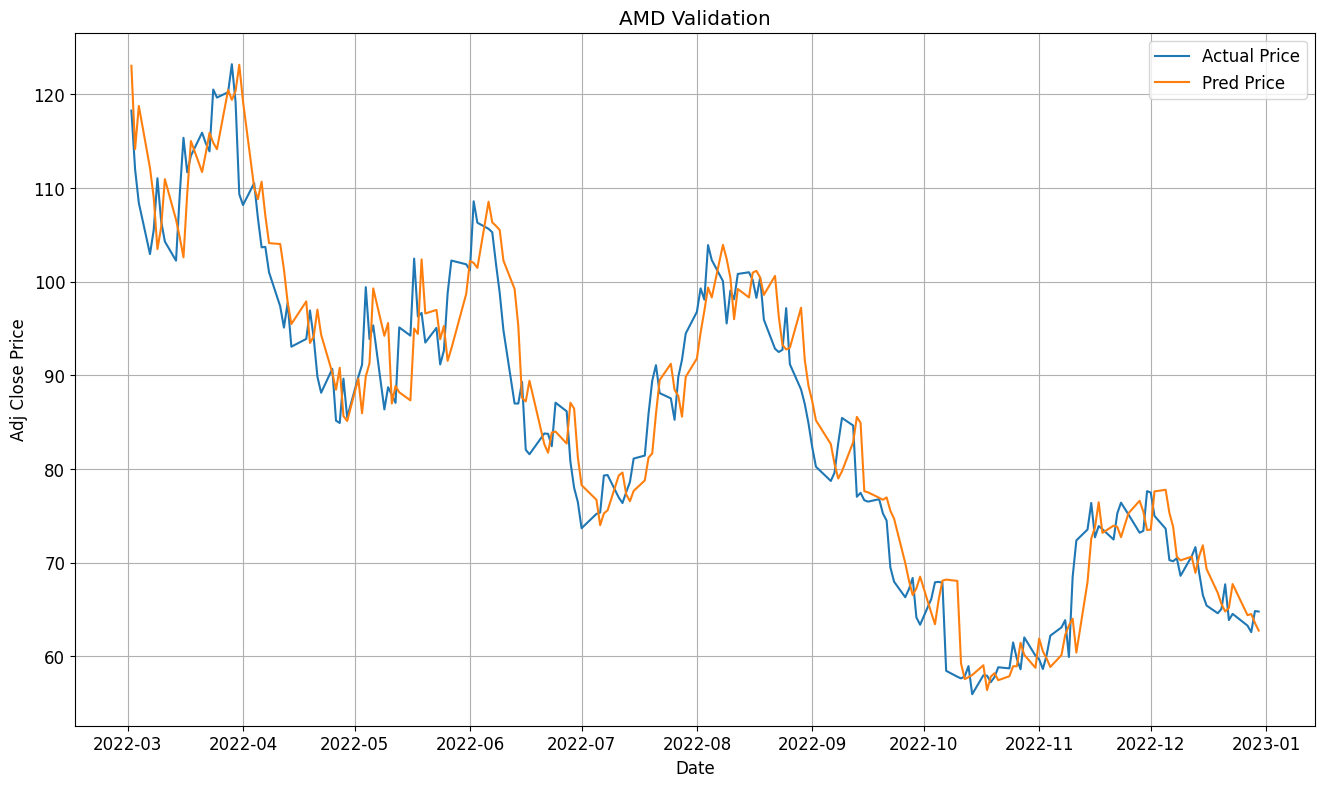

In [50]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')
plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()

We can observe the validation RMSE value go down steadily.

In [51]:
model_loss_df.tail()

,AAPL,AMD,INTC,MSFT,NVDA
6000,0.000159,0.000199,0.000804,0.000153,0.000172
7000,0.000156,0.000199,0.000800,0.000152,0.000175
8000,0.000155,0.000199,0.000800,0.000151,0.000171
9000,0.000155,0.000200,0.000799,0.000151,0.000171
10000,0.000155,0.000199,0.000799,0.000157,0.000170


The loss values for all the stocks have decreased significantly without any tradeoff in execution time. The decrease in th loss with the number of iterations has gone down suggesting that the higher number of hidden layers are helping the models learn quicker and reach the global minima earlier than the previous models.

In [52]:
pred_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-08,40.913406,12.134758,38.261715,81.914299,52.989609
2018-01-09,41.320610,12.023273,38.285877,82.806282,53.299938
2018-01-10,41.302902,12.247670,38.390945,83.190620,54.799652
2018-01-11,41.263729,11.981873,37.769749,83.207985,55.018547
2018-01-12,41.255760,11.946534,36.901859,82.946922,55.334885


In [53]:
model_perf_df

,AAPL,AMD,INTC,MSFT,NVDA
MAE,1.449496,1.555805,0.884141,2.681492,2.892105
MSE,4.743305,5.796032,1.707688,15.340907,22.068866
RMSE,2.177913,2.407495,1.306785,3.916747,4.697751
MAPE,1.487031,2.584612,2.224571,1.416132,2.368696
MPE,-0.062272,-0.203779,-0.876406,-0.542877,-0.199973


Even though the decrease in the losses has been consistent with the increase in the number of hidden units, the same cannot be said for other perfromance metrics. 

After increasing the hidden units to 100, the MAE, MSE, and RMSE values have mostly decreased, except for a slight increase in errors for the AMD and NVDA models. This indicates the updated models are continuing to make more precise return predictions overall, just with marginal accuracy losses for AMD and NVDA.

With its lowest errors across the board, the INTC model again seems to be performing the best in absolute forecasting accuracy. However, INTC's Mean Percentage Error worsened significantly, meaning it is underestimating returns by a wider proportional degree.

Both the MSFT and NVDA models now also have worse underestimation bias per their higher Mean Percentage Errors, despite MSFT showing improved error rates. So while some models are more precise (lower MAE, MSE), their proportional inaccuracies have amplified.

MAPE values increased for many models as well, implying returns forecasts are deviating more as a percentage of actuals. Only AAPL shows marginal improvement in percentage error terms.

In summary, the additional hidden units continue to refine accuracy for some assets but not all, as evidenced by fluctuating metrics. Tradeoffs are accelerating between precision gains and deterioration in proportional inaccuracies—several models with better MSE/MAE are underestimating more severely or seeing higher MAPE. Performance is not uniformly improving. 

Let's try and see if there is a point after which increasing the number of hidden units results in performance deterioration.

### Further increasing the number of hidden units:

In [54]:
start = time.time()
run_experiment(n_input = 1, n_hidden = 100, n_layers = 1, n_classes = 1, nepochs = 10000, lr = 0.001)
Time = (time.time() - start) / 60/ 60
print("Time Elapsed: " , Time)

----------
AAPL fitting...
4 left
Done!
----------
AMD fitting...
3 left
Done!
----------
INTC fitting...
2 left
Done!
----------
MSFT fitting...
1 left
Done!
----------
NVDA fitting...
0 left
Done!
Time Elapsed:  0.03524752742714352


First off, we can see that the execution time has increased significantly. Now, the degree of perfromance improvement will be a key factor in determining whether the increased execution time is a worthy trade off.

Val RMSE: 102.52647170536711


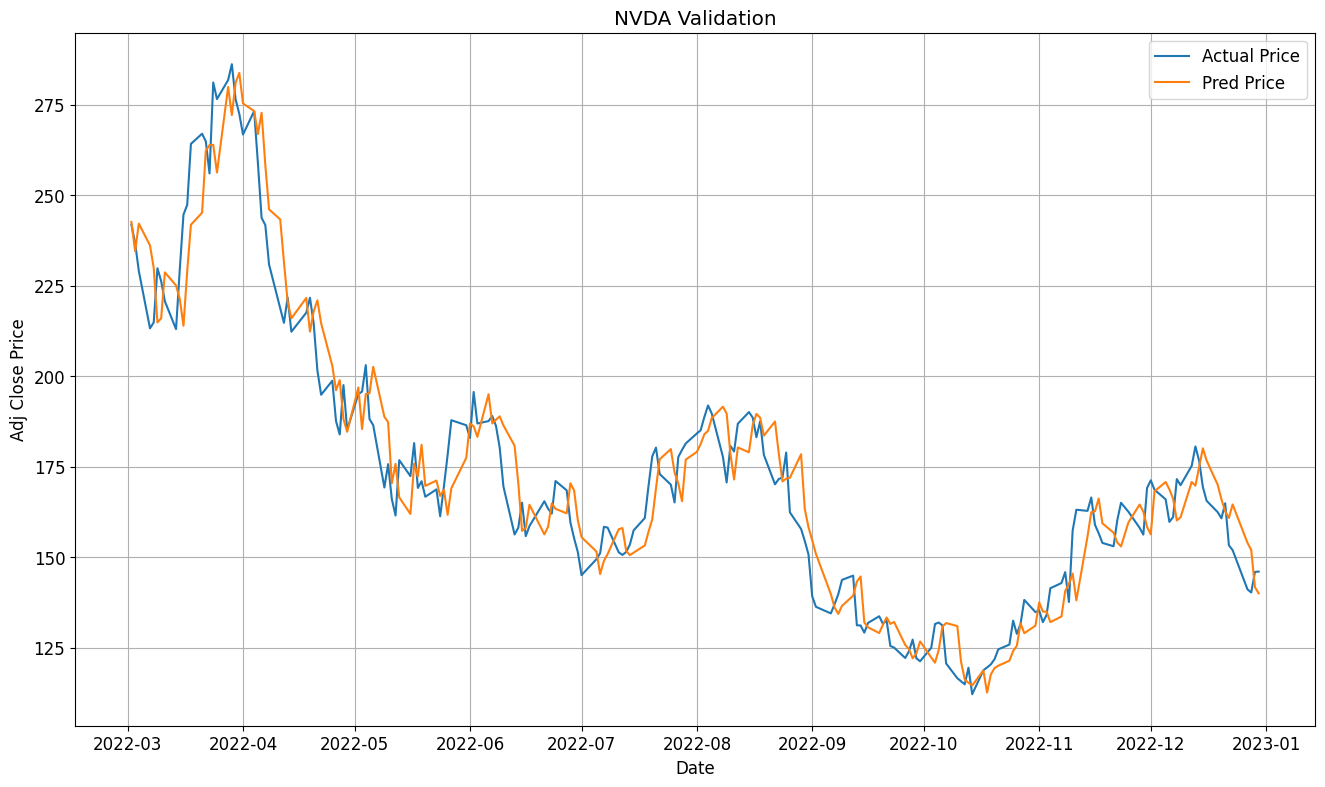

In [56]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')
plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()

The previous Val RMSE obtained for NVDA for the simplest LSTM model was 104.36. The validation RMSE obtained now with 100 hidden units is 102.56. Let's evaluate the other performance metrics to get a complete understanding of the improvements.

In [57]:
model_loss_df.tail()

,AAPL,AMD,INTC,MSFT,NVDA
6000,0.000156,0.000199,0.000802,0.000152,0.000171
7000,0.000155,0.000199,0.000802,0.000151,0.000171
8000,0.000155,0.000199,0.000801,0.000151,0.000171
9000,0.000156,0.000199,0.000800,0.000151,0.000170
10000,0.000155,0.000199,0.000806,0.000151,0.000171


We can see that there is not much of a change in the loss values from 6000 epochs to 10000 epochs which indicates that the increased hidden layers have caused the model to learn the patterns way earlier than the previous models. The loss value is almost constant through out the epochs.

In [58]:
pred_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-08,40.915443,12.113544,38.082874,81.377785,52.679626
2018-01-09,41.328400,12.036003,38.110809,82.259567,52.831890
2018-01-10,41.312931,12.243802,38.225166,82.670303,54.326977
2018-01-11,41.261776,12.005992,37.564415,82.698898,54.625923
2018-01-12,41.256851,11.957075,36.623486,82.448006,54.850449


In [59]:
model_perf_df

,AAPL,AMD,INTC,MSFT,NVDA
MAE,1.448834,1.557336,0.787347,2.582759,2.957737
MSE,4.741725,5.797594,1.270374,14.368442,22.190759
RMSE,2.177550,2.407819,1.127109,3.790573,4.710707
MAPE,1.486272,2.589582,1.855761,1.356511,2.464665
MPE,-0.062742,-0.200814,-0.305501,-0.132484,0.506425


The other metrics show that the improvements are similar to the ones we obtained from the previous experiment. They are very inconsistent among the stocks.

The INTC model has seen further improvements in forecasting accuracy - reducing errors across the board to the lowest MAE, MSE and RMSE values. It appears to now be predicting returns most precisely.

However, INTC's Mean Percentage Error and Mean Absolute Percentage Error have worsened. So while its forecasts may have the smallest absolute errors, the predictions tend to increasingly deviate in proportional terms vs realized returns.

The AAPL model shows marginal mixed changes, with a slight reduction in MAE but increased inaccuracy per MAPE. So minor give-and-take in AAPL performance.

Interestingly, the NVDA model now has a positive Mean Percentage Error, indicating a switch to overestimating projected returns.
An overestimation proportional bias has emerged, even as its errors and MAPE have worsened slightly.

In summary, the tuned INTC LSTM model predicts returns with the highest outright accuracy, but proportional inaccuracies remain high. The AAPL and NVDA models showcase fluctuating metrics and estimate biases as tuning continues - highlighting the ongoing tradeoffs between precision gains and introducing new proportional errors. Model refinement is incremental and uneven.

### Trying to find the breaking point for the improvement in performance with hidden units

In [60]:
start = time.time()
run_experiment(n_input = 1, n_hidden = 1000, n_layers = 1, n_classes = 1, nepochs = 10000, lr = 0.001)
Time = (time.time() - start) / 60/ 60
print("Time Elapsed: " , Time)

----------
AAPL fitting...
4 left
Done!
----------
AMD fitting...
3 left
Done!
----------
INTC fitting...
2 left
Done!
----------
MSFT fitting...
1 left
Done!
----------
NVDA fitting...
0 left
Done!
Time Elapsed:  0.33469626910156675


By increasing the number of hidden units from 100 to 1000, we also see a ten fold increase in the execution time. This might not be a worthy trade off for a slight improvement in perfromance.

Val RMSE: 22.304714688235922


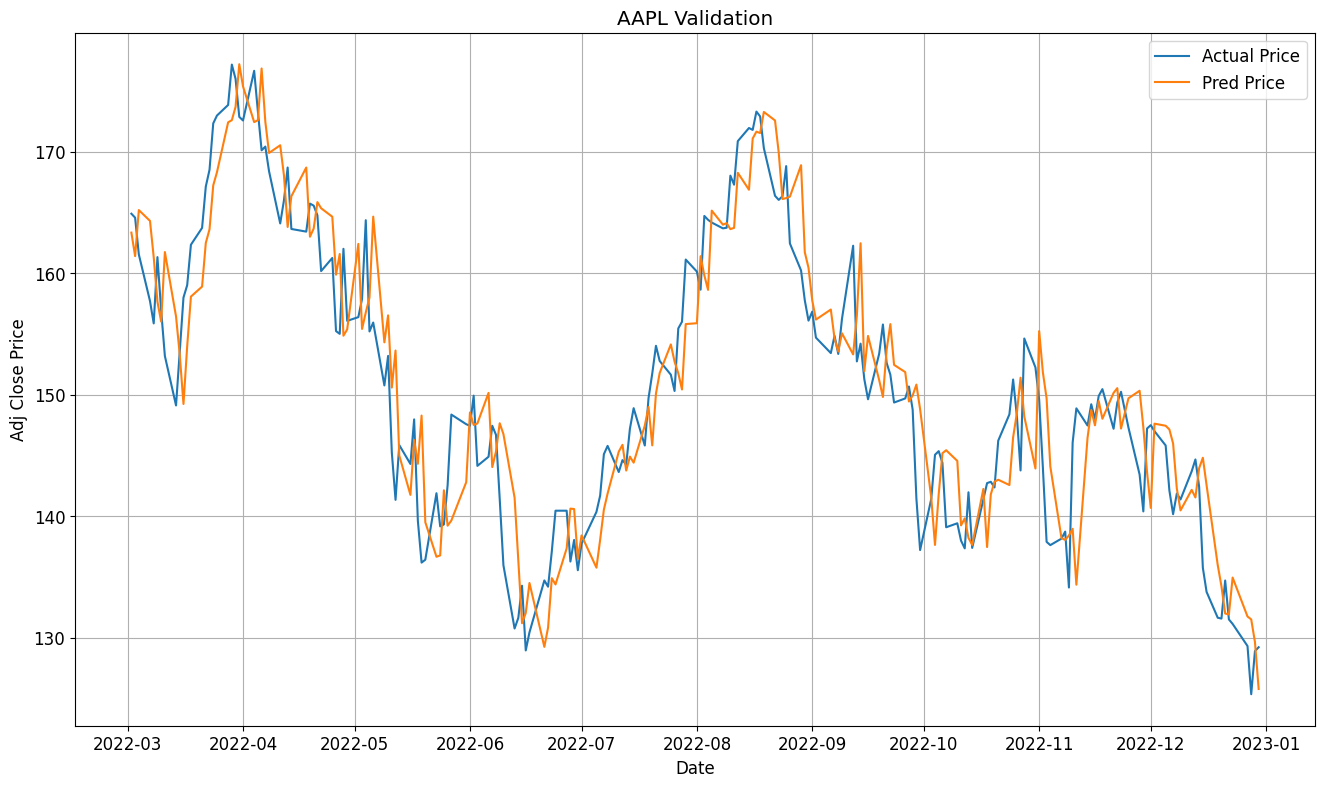

In [62]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')
plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()

The validation error or AAPL stock is the same as the RMSE obtained from the model with 10 hidden units. So, we cannot see much improvement on this front. Let's examine other metrics to see if there is any significant and consistent improvement.

In [63]:
model_loss_df.tail()

,AAPL,AMD,INTC,MSFT,NVDA
6000,0.000155,0.000200,0.000803,0.000151,0.000171
7000,0.000155,0.000199,0.000802,0.000152,0.000171
8000,0.000155,0.000199,0.000801,0.000151,0.000170
9000,0.000155,0.000213,0.000803,0.000152,0.000171
10000,0.000155,0.000203,0.000799,0.000153,0.000170


From the above result, we can see that the loss value has become stagnant over the epochs suggesting that there is no improvement in the perfromance of the model with the epochs. Also, it is worth noting that the loss values for all the stocks are almost the same as the previous experiments. So, even with the trade off of execution time there is no improvement in loss values.

In [64]:
pred_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-08,40.858089,12.106640,38.158047,80.857079,53.160229
2018-01-09,41.256630,11.957649,38.223938,81.728317,53.279381
2018-01-10,41.258736,12.151416,38.373955,82.147072,54.860977
2018-01-11,41.215519,11.893514,37.705624,82.208992,55.064243
2018-01-12,41.207458,11.819804,36.752464,81.966591,55.297375


In [65]:
model_perf_df

,AAPL,AMD,INTC,MSFT,NVDA
MAE,1.452058,1.608999,0.820733,2.599236,2.893321
MSE,4.748802,6.030339,1.398438,14.313037,22.015875
RMSE,2.179175,2.455675,1.182556,3.783257,4.692108
MAPE,1.492370,2.661546,1.988471,1.373812,2.371428
MPE,-0.042965,-0.469392,-0.630634,0.130238,-0.013304


The increase in number of hidden layers to such a high value has introduced instability in the models' perfromane.

The MAE, MSE, and RMSE have increased for several models, indicating a recent decline in absolute forecast accuracy for AAPL, AMD, INTC and MSFT. Only the NVDA model preserved its low error rates.

AMD experienced the largest accuracy drop with significantly higher errors. Its predictions seemingly became much less precise.\

INTC remains the top performer in terms of low absolute errors, but its Mean Percentage Errors worsened as estimates are more largely underestimating returns.

MSFT is now slightly overestimating on average with a positive MPE, though its errors rose mildly.

NVDA stands out as maintaining errors while reducing its small underestimation bias to near zero. It is estimating returns with similar accuracy and low percentage deviation.

In summary, recent model instability has emerged, with absolute precision metrics worsening across assets excluding NVDA. Declining MAE/MSE show prediction accuracy backsliding for most models. Biases are also amplifying, as multiple former under-estimators now overestimate or vice versa. The volatility highlights the ongoing struggle to balance accuracy gains with percentage errors.

From the above, it is clear that there is an optimal range beyond which no favorable results will be obtained by increasing the complexity of the model. 

### Increasing Number of Layers:

In [66]:
start = time.time()
run_experiment(n_input = 1, n_hidden = 100, n_layers = 5, n_classes = 1, nepochs = 10000, lr = 0.001)
Time = (time.time() - start) / 60/ 60
print("Time Elapsed: " , Time)

----------
AAPL fitting...
4 left
Done!
----------
AMD fitting...
3 left
Done!
----------
INTC fitting...
2 left
Done!
----------
MSFT fitting...
1 left
Done!
----------
NVDA fitting...
0 left
Done!
Time Elapsed:  0.1681702013148202


The execution time has increased three fold comapred to the single layered 100 hidden unit LSTM model. However, no significant difference can be seen in the actual vs predicted prices of trainingand validation data. 

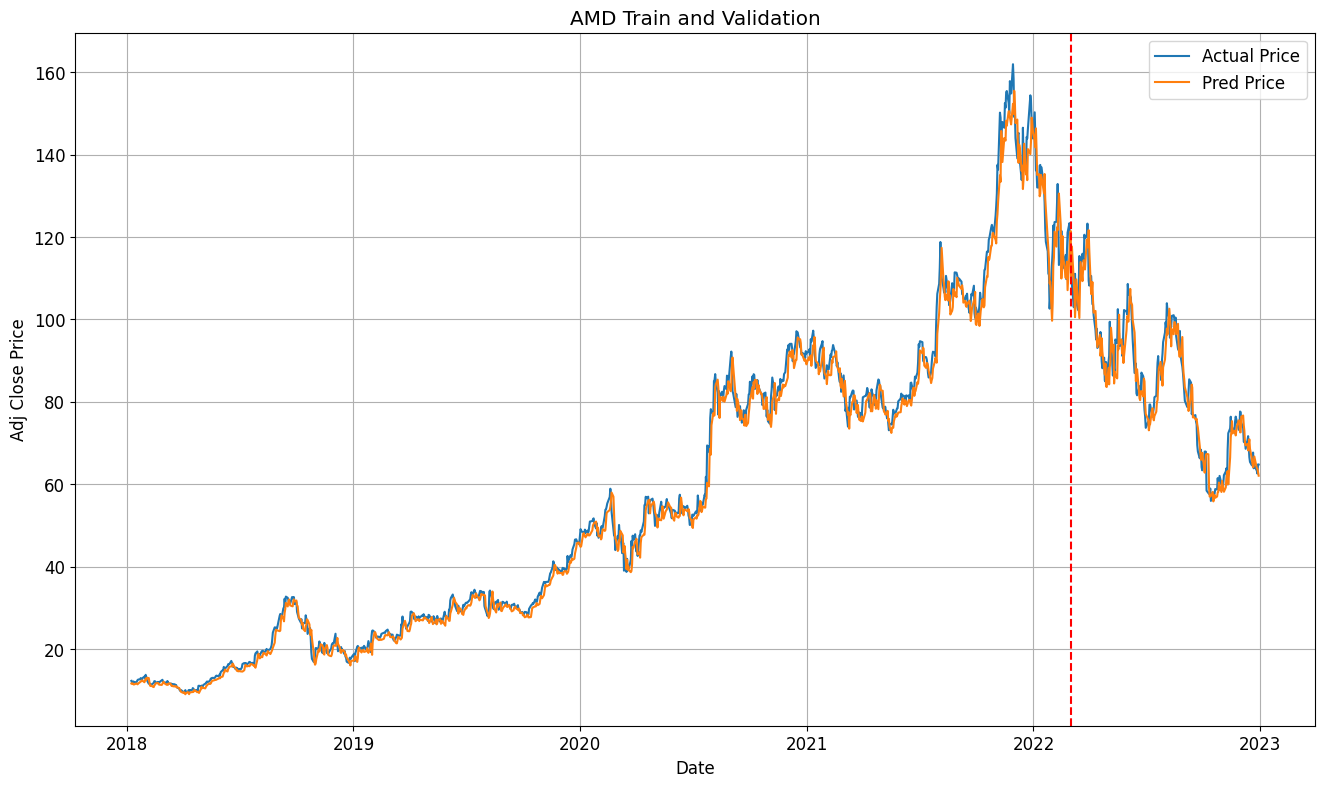

In [67]:
# plotting actual and predicted Adj Close price of random ticker
rand_ticker = random.choice(tickers)
plt.plot(pred_adj_close_df.index, act_adj_close_df[rand_ticker][time_step + 1:], label='Actual Price')
plt.plot(pred_adj_close_df.index, pred_adj_close_df[rand_ticker], label='Pred Price')
plt.axvline(x=pred_adj_close_df.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Train and Validation')
plt.legend()
plt.show()

The val RMSE for AMD with one layer and 50 hidden units was also 20.8. So, there is not much improvement in the RMSE values. From the graph, it can also be seen that the predicted values are fluctuating alot.

Val RMSE: 20.75697305012196


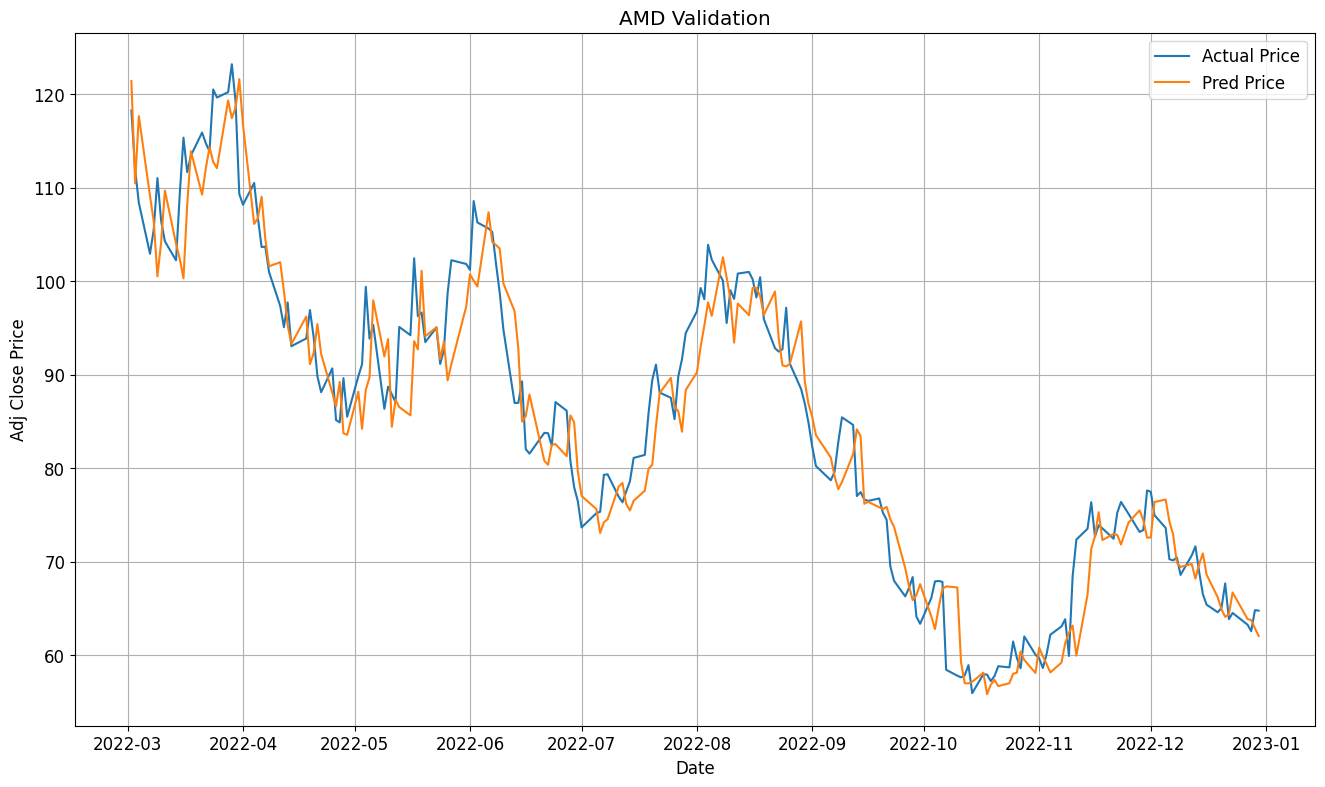

In [68]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')
plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()

In [69]:
model_loss_df.tail()

,AAPL,AMD,INTC,MSFT,NVDA
6000,0.000154,0.000226,0.000793,0.00015,0.000166
7000,0.000152,0.000196,0.000787,0.00015,0.000165
8000,0.000152,0.000198,0.000721,0.00015,0.000165
9000,0.000152,0.000195,0.000663,0.00015,0.000165
10000,0.000155,0.000277,0.000595,0.00018,0.000164


One more interesting observation is that with the increase in number of iterations the loss value seems to be increasing for most of the stocks.

In [70]:
pred_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-08,40.757401,11.620930,38.670288,79.913422,52.913406
2018-01-09,41.140015,11.525902,38.428574,80.681564,53.066032
2018-01-10,41.157730,11.684130,38.087410,81.191849,54.458828
2018-01-11,41.102707,11.479388,37.555359,81.340866,54.915016
2018-01-12,41.097546,11.381307,37.186111,81.163467,55.107563


In [71]:
model_perf_df

,AAPL,AMD,INTC,MSFT,NVDA
MAE,1.466684,1.835856,1.074533,2.872684,2.875491
MSE,4.778496,7.146054,3.926368,15.381769,21.623589
RMSE,2.185977,2.673211,1.981507,3.921960,4.650117
MAPE,1.513275,3.251568,3.026173,1.614630,2.371225
MPE,0.165483,2.111672,-1.717346,0.693428,-0.137670


After increasing the number of layers:

Interestingly, the absolute forecasting errors like MAE, MSE and RMSE have remained unchanged across all assets after adding layers. So prediction accuracy is preserved in absolute terms of deviation from actuals.
However, the proportional accuracy metrics have substantially worsened for several models. MAPE shot up markedly for AMD and INTC implying their return ratios diverged more from reality.

AMD and INTC also saw their estimate biases amplify severely, with AMD now overestimating by over 200% while INTC underestimates by nearly 200%. The additional LSTM layers have clearly distorted proportional accuracy.

Comparatively, MSFT and NVDA were relatively unaffected regarding proportional errors. MSFT maintained its slight overestimation while NVDA saw its small underestimation percentage shrink further.
AAPL meanwhile flipped its bias, moving from over to underestimating returns on average after adding model layers, albeit still with mild percentage error.

In summary, increasing LSTM layers preserved absolute forecasting precision but sacrificied proportional inaccuracies for assets like AMD and INTC. This likely points to overfitting models as more layers extract spurious patterns. The impacts highlight the difficulty in balancing predictive quality across both absolute and relative metric perspectives.

## 6.2 Using slightly Larger Time Step (7 days):

In [72]:
time_step = 7

In [73]:
# dataframes for model loss, predicted Adj Close price and model performance
model_loss_df = pd.DataFrame(index=[epoch for epoch in range(0, 11000, 1000)], columns=tickers)
pred_adj_close_df = pd.DataFrame(index=df.index[time_step + 1:], columns=tickers)
model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'], columns=tickers)

In [74]:
start = time.time()
run_experiment(n_input = 1, n_hidden = 50, n_layers = 5, n_classes = 1, nepochs = 10000, lr = 0.001)
Time = (time.time() - start) / 60/ 60
print("Time Elapsed: " , Time)

----------
AAPL fitting...
4 left
Done!
----------
AMD fitting...
3 left
Done!
----------
INTC fitting...
2 left
Done!
----------
MSFT fitting...
1 left
Done!
----------
NVDA fitting...
0 left
Done!
Time Elapsed:  0.05883272952503628


The time taken for execution has decreased significantly as we increase the time step. But from the below cell, the Val RMSE value for NVDA has increased from the values we have seen in the 3-day time step models which were 104 and 102.

Val RMSE: 108.76630657684488


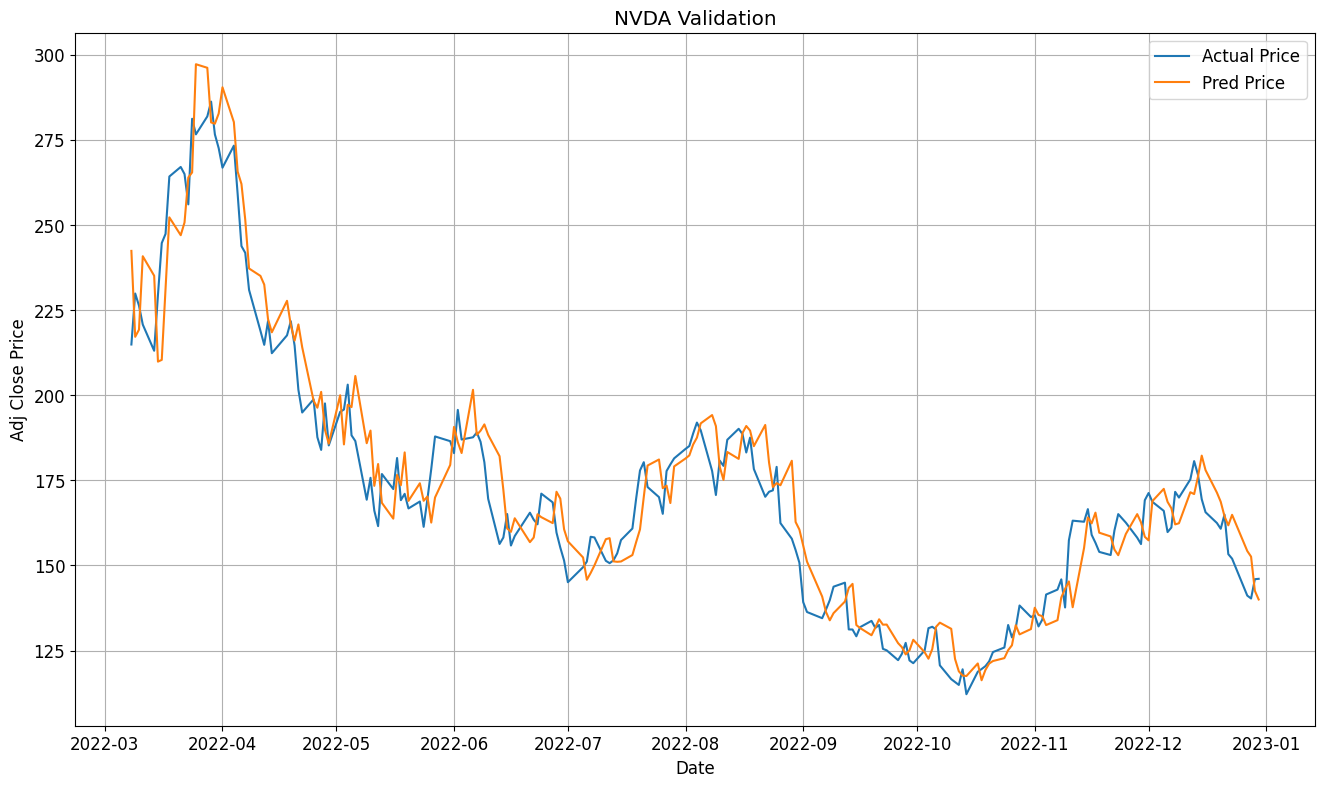

In [76]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')
plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()


In [77]:
model_loss_df.tail()

,AAPL,AMD,INTC,MSFT,NVDA
6000,0.000153,0.000193,0.000971,0.000158,0.000146
7000,0.000152,0.000189,0.000580,0.000150,0.000331
8000,0.000151,0.000189,0.000527,0.000149,0.000137
9000,0.000150,0.000196,0.000341,0.000149,0.000111
10000,0.000156,0.000149,0.000259,0.000149,0.000085


The loss values for the models can also be observed to be increasing with the number of epochs. This might be a sign of slight decline in models' performance.

In [78]:
pred_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-12,40.785549,11.818641,36.914536,82.793793,55.170650
2018-01-16,40.976398,12.004263,37.218723,82.710503,55.351055
2018-01-17,41.359394,11.933583,36.565517,83.344025,55.099285
2018-01-18,41.241581,11.838712,37.509735,83.424698,54.436409
2018-01-19,41.790287,12.041736,38.025772,83.923286,55.198669


In [79]:
model_perf_df

,AAPL,AMD,INTC,MSFT,NVDA
MAE,1.528084,1.564695,0.549107,2.573965,2.644295
MSE,4.995828,5.985071,0.596038,14.166156,18.063275
RMSE,2.235135,2.446441,0.772035,3.763795,4.250091
MAPE,1.615230,2.634598,1.339840,1.359981,2.292984
MPE,0.208265,-0.373922,-0.231530,-0.072638,-0.211866


After both increasing LSTM time steps and adding layers:

Compared to the previous metrics, both MAE and MSE have dropped across all models, indicating improved absolute accuracy in terms of lower prediction errors. So the combined adjustments have enhanced precision.

Potential overfitting from too many layers seems to be mitigated by the longer time step. By forcing the model to see farther back, spurious signals are likely filtering out.

INTC and MSFT show marked proportional improvements as well, with their Mean Percentage Errors dropping close to zero. Estimates are no longer largely over or under projecting.

MAPE has also decreased for several assets, implying percentage-wise estimates are hewing closer to reality. AMD MAPE remains high though, suggesting its proportional accuracy still lags.

Estimate biases have also tempered - most models show modest flipping between slightly over or underestimating, versus more severe biases before tuning.

In essence, increasing both model depth and time horizons appears to have augmented accuracy and proportional reliability for many assets. This showcases the value of multi-parameter tuning to hone predictive quality from different error perspectives.

### Incresing number of layers:

In [80]:
start = time.time()
run_experiment(n_input = 1, n_hidden = 100, n_layers = 10, n_classes = 1, nepochs = 10000, lr = 0.001)
Time = (time.time() - start) / 60/ 60
print("Time Elapsed: " , Time)

----------
AAPL fitting...
4 left
Done!
----------
AMD fitting...
3 left
Done!
----------
INTC fitting...
2 left
Done!
----------
MSFT fitting...
1 left
Done!
----------
NVDA fitting...
0 left
Done!
Time Elapsed:  0.5123012517558203


The execution time has increassed significantly. 

In [81]:
model_loss_df.tail()

,AAPL,AMD,INTC,MSFT,NVDA
6000,0.000168,0.000163,1.132386e-05,0.000146,0.000153
7000,0.000118,0.000165,4.797597e-07,0.000147,0.000077
8000,0.000333,0.000096,9.465102e-08,0.000139,0.000064
9000,0.000108,0.000200,9.296071e-07,0.000180,0.000060
10000,0.000085,0.000082,1.546321e-07,0.000207,0.000056


We are also able to obtain the lowest loss values using both increased layers and a slight increase in time step. Surprisingly this positive imapct is also consistent with all the stocks.

In [82]:
pred_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-01-12,41.371731,11.935804,36.931011,82.043297,55.274651
2018-01-16,41.633297,12.163172,36.787529,82.085625,55.461376
2018-01-17,42.106037,12.090248,36.702477,82.748436,55.257149
2018-01-18,41.851334,11.972367,37.763546,82.694496,54.636921
2018-01-19,42.573326,12.192027,37.842606,83.172958,55.376625


In [83]:
model_perf_df

,AAPL,AMD,INTC,MSFT,NVDA
MAE,1.467315,1.379257,0.757732,3.054769,2.662268
MSE,6.442259,5.732609,5.769949,16.630728,25.461698
RMSE,2.538161,2.394287,2.402072,4.078079,5.045959
MAPE,1.490774,2.490346,2.627451,1.679156,2.358050
MPE,-0.362500,-0.357789,-2.476165,1.008774,-0.082692


The values seem to be consistent with the previous models which is where the question of whether the trade off of higher execution time is worthy arises. Even though the loss values we have obtained have been the lowest the other performance metrics have shown little to no significant improvement for such a large increase in the execution time.

## 6.3 Using 30 day time step

In [84]:
time_step = 30

In [85]:
# dataframes for model loss, predicted Adj Close price and model performance
model_loss_df = pd.DataFrame(index=[epoch for epoch in range(0, 11000, 1000)], columns=tickers)
pred_adj_close_df = pd.DataFrame(index=df.index[time_step + 1:], columns=tickers)
model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'], columns=tickers)

In [86]:
start = time.time()
run_experiment(n_input = 1, n_hidden = 50, n_layers = 10, n_classes = 1, nepochs = 10000, lr = 0.001)
Time = (time.time() - start) / 60/ 60
print("Time Elapsed: " , Time)

----------
AAPL fitting...
4 left
Done!
----------
AMD fitting...
3 left
Done!
----------
INTC fitting...
2 left
Done!
----------
MSFT fitting...
1 left
Done!
----------
NVDA fitting...
0 left
Done!
Time Elapsed:  0.37753944741355044


We can see that the time taken for execution is similar to the model with 7 day time step.

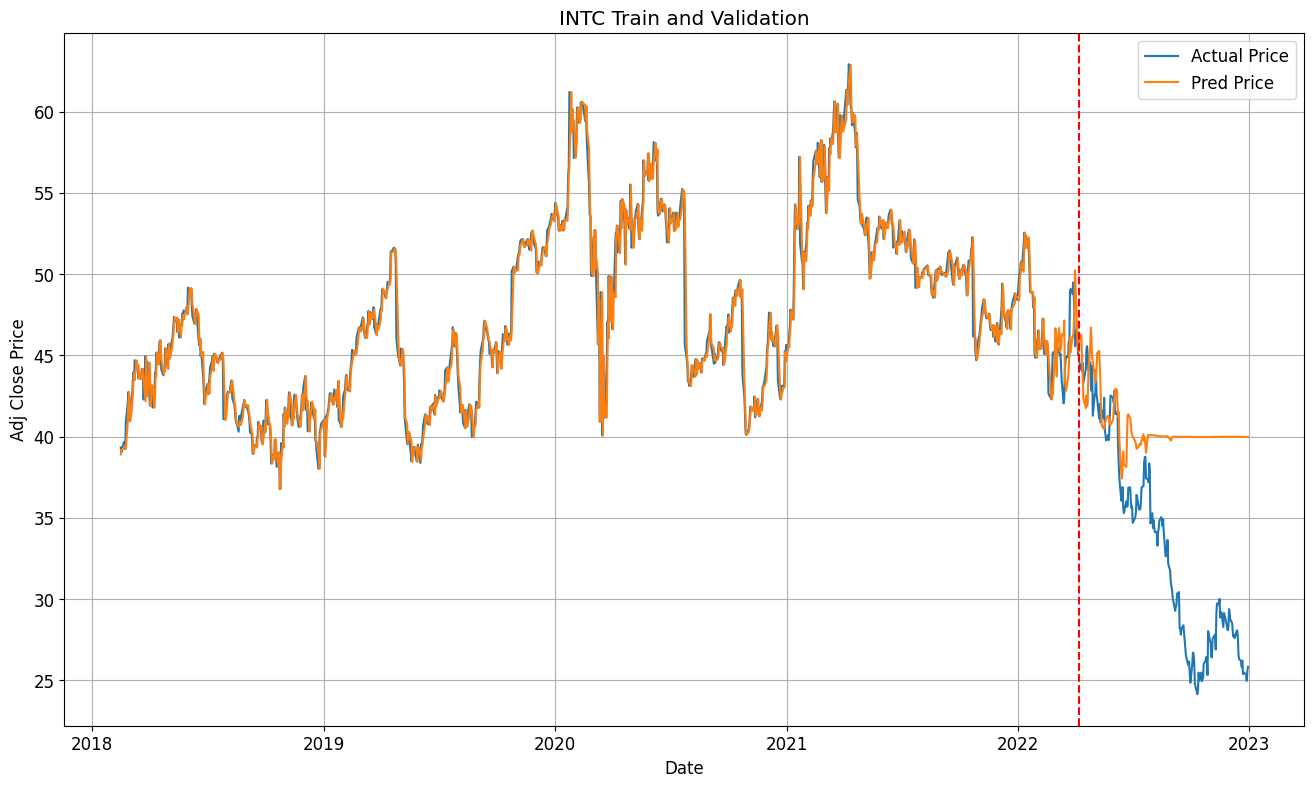

In [87]:
# plotting actual and predicted Adj Close price of random ticker
rand_ticker = random.choice(tickers)
plt.plot(pred_adj_close_df.index, act_adj_close_df[rand_ticker][time_step + 1:], label='Actual Price')
plt.plot(pred_adj_close_df.index, pred_adj_close_df[rand_ticker], label='Pred Price')
plt.axvline(x=pred_adj_close_df.index[all_split], c='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Train and Validation')
plt.legend()
plt.show()

From the graph we can see that the perfromance has deteriorated significantly for validation data. The model performed well on the training data, but failed to predict the values for unseen data. This indicates that the model is unable to generalize the data.

Val RMSE: 83.41908640872595


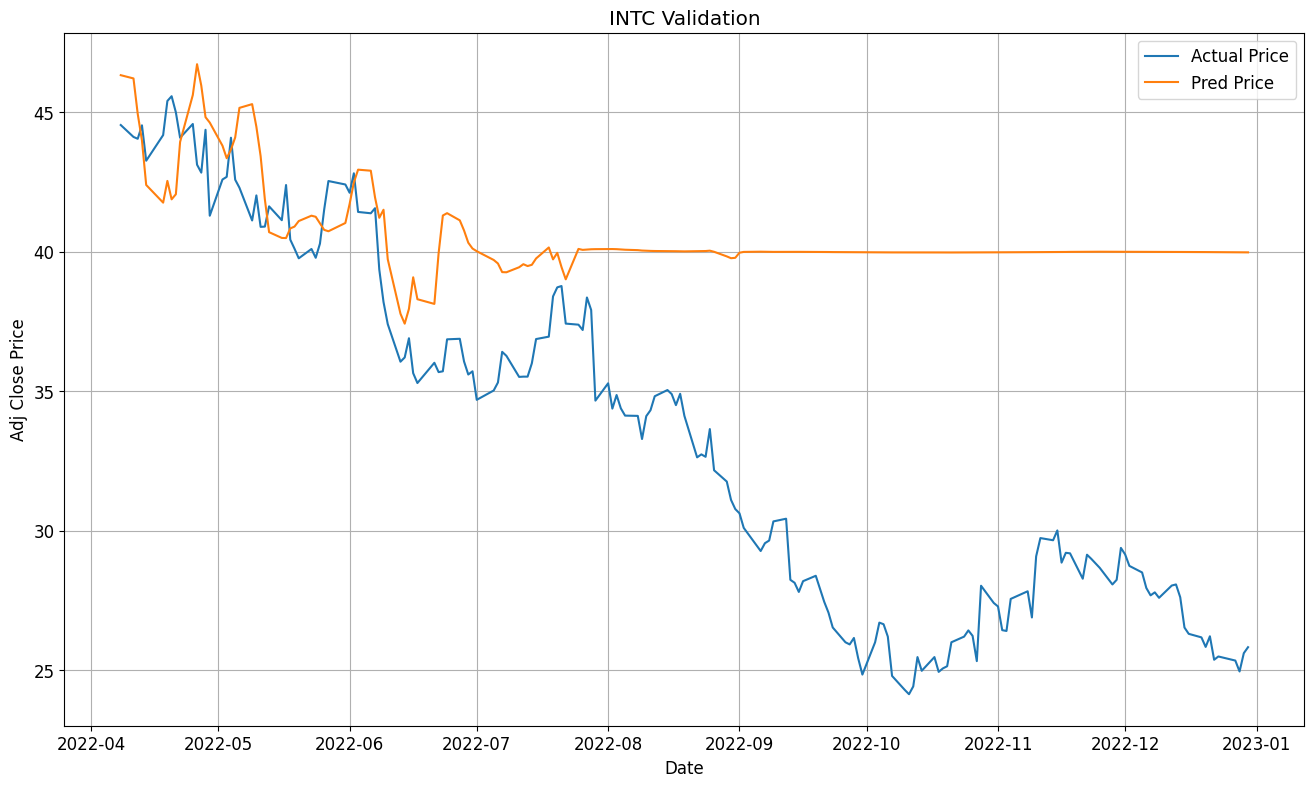

In [88]:
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')
plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title(f'{rand_ticker} Validation')
plt.legend()
plt.show()


From the zoomed in graph, we can see that the values are completely off as the time progresses.

In [89]:
model_loss_df.tail()

,AAPL,AMD,INTC,MSFT,NVDA
6000,0.000238,0.000139,0.000051,0.000105,0.000168
7000,0.000245,0.001148,0.000010,0.000124,0.000155
8000,0.000159,0.000129,0.000041,0.000102,0.000115
9000,0.000165,0.000114,0.000072,0.000100,0.000092
10000,0.000130,0.000114,0.000001,0.000094,0.000086


The losses seem to decrease with the epochs but not it is obvious from the graph that these values do not carry much significance.

In [90]:
pred_adj_close_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2018-02-15,38.734013,11.708052,38.894756,84.924118,58.432438
2018-02-16,39.315701,11.959981,39.185757,85.676247,60.372368
2018-02-20,40.534565,12.011975,39.272400,86.657700,62.011520
2018-02-21,40.626305,11.744973,39.442883,86.936790,61.487152
2018-02-22,40.499340,11.885301,39.369087,86.921127,62.131531


In [91]:
model_perf_df

,AAPL,AMD,INTC,MSFT,NVDA
MAE,2.183619,1.513216,1.181580,3.389239,3.573383
MSE,22.849504,5.774370,12.404029,43.415094,67.359902
RMSE,4.780115,2.402992,3.521935,6.589013,8.207308
MAPE,1.971679,2.596569,4.046146,1.665047,2.939368
MPE,-0.282873,0.043100,-3.792628,-0.541678,-1.889850


All the errors have also increased significantly from the previous models. The MSE values across all the stocks have resurged and the same is the case with RMSE and MAE. Hence we can conclude that while ncreasing the time step and considering a longer historical context can be beneficial for capturing long-term dependencies, it may also introduce noise or irrelevant information. The model might struggle to distinguish between relevant and non-relevant information in the extended sequence. Also, training a model with longer time steps requires a sufficiently large dataset to provide diverse examples of sequences. Since we only considered 5 years of historic data 30 days might be a huge time step.

## 7. Building portfolios

In the below cell, we calculates the daily returns of the actual adjusted close prices during the validation phase. The selection starts from the index 'time_step + 1 + all_split onward'. The pct_change() function computes the percentage change between the current and a prior element which is used to calculate the percentage change in the adjusted close prices to obtain daily returns. The first row of the DataFrame is then removed since the percentage change for the first day is undefined.

In [98]:
# daily returns of actual Adj Close price (validation phase)
act_adj_close_val_df = act_adj_close_df.iloc[time_step + 1 + all_split:, :]
act_daily_ret_df = act_adj_close_val_df.pct_change()
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]
act_daily_ret_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2022-04-11,-0.025516,-0.035941,-0.009570,-0.039431,-0.051992
2022-04-12,0.011523,-0.023313,-0.001503,-0.011218,-0.018844
2022-04-13,0.016342,0.027760,0.010968,0.019712,0.032506
2022-04-14,-0.029988,-0.047882,-0.028504,-0.027084,-0.042562
2022-04-18,-0.001331,0.008919,0.021239,0.002466,0.024697


We did the same thing below for the predicted adjusted close values as well. This information is valuable for comparing the model's performance against the actual market behavior. 

In [99]:
# daily returns of predicted Adj Close price (validation phase)
pred_adj_close_val_df = pred_adj_close_df.iloc[all_split:, :]
pred_daily_ret_df = pred_adj_close_val_df.pct_change()
pred_daily_ret_df = pred_daily_ret_df.iloc[1:, :]
pred_daily_ret_df.head()

,AAPL,AMD,INTC,MSFT,NVDA
Date,,,,,
2022-04-11,-0.005793,-0.033224,-0.005659,0.013408,0.015455
2022-04-12,-0.005859,-0.014111,-0.008608,-0.018089,0.011573
2022-04-13,-0.019105,-0.018205,0.021008,-0.040027,-0.208209
2022-04-14,0.017254,-0.031907,0.027414,-0.023496,-0.016319
2022-04-18,-0.007751,0.049534,-0.066229,0.004184,-0.110721


Now, we drop the columns corresponding to individual tickers from the act_daily_port_ret_df. The tickers variable contains a list of ticker symbols used in the original DataFrame (act_daily_ret_df). The resulting DataFrame (act_daily_port_ret_df) now contains only the columns related to the overall portfolio returns, excluding individual stock returns.

In [100]:
# dataframe for daily portfolio returns
act_daily_port_ret_df = act_daily_ret_df.copy()
act_daily_port_ret_df.drop(columns=tickers, inplace=True)

The risk-free rate is the return on an investment that is considered to have no risk of financial loss. In practice, it is often associated with the yield on government bonds, such as U.S. Treasury bonds. Investors use the risk-free rate as a baseline when assessing the attractiveness of other investments, factoring in the additional risk associated with those investments. We have assigned a specific value (0.015) to represent the assumed risk-free rate.

In [101]:
# risk free return
risk_free_ret = 0.015

We defined a function, 'add_portfolio' that calculates and adds a portfolio's returns and cumulative product returns to the act_daily_port_ret_df DataFrame. This is done by taking the dot product of the individual stock returns (act_daily_ret_df) with the given weights (weights). The result is added as a new column in the act_daily_port_ret_df DataFrame. For the predicted portfolio, a transaction cost adjustment is applied by subtracting a fixed amount (0.0003, which is the upper bound of security transaction tax) from the portfolio returns. This adjustment simulates a transaction cost, and it's common in financial modeling to account for the impact of trading expenses. Then we calculate the cumulative product returns by taking the cumulative product of (1 + portfolio returns) for each day. Various performance metrics for the portfolio, including the expected return, standard deviation, and Sharpe ratio are then calculated. The Sharpe ratio is computed as the ratio of the excess expected return over the risk-free rate to the standard deviation.

__Importance of Sharpe Ratio in portfolio management:__

The Sharpe Ratio adjusts the raw return of an investment or portfolio for the level of risk taken. It provides a more comprehensive measure of performance by considering both returns and risk. Investors and portfolio managers can use the Sharpe Ratio to compare the risk-adjusted performance of different portfolios. It helps assess whether the excess return generated by a portfolio is sufficient given the level of risk it carries. The Sharpe Ratio quantifies the excess return earned per unit of risk (standard deviation). Higher Sharpe Ratios indicate better risk-adjusted returns, while lower ratios suggest that the portfolio may not be adequately compensating for the risk taken. 

In [102]:
# function for adding different portfolios
def add_portfolio(portfolio, weights):
    act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_ret_df.dot(weights)
    if portfolio == 'Pred':
        # upper bound of security transaction tax: 0.0003
        act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_port_ret_df[f'{portfolio} Return'] - 0.0003
    act_daily_port_ret_df[f'{portfolio} Cum Prod Return'] = (1 + act_daily_port_ret_df[f'{portfolio} Return']).cumprod()

    exp_ret = act_daily_port_ret_df[f'{portfolio} Return'].mean()
    std = act_daily_port_ret_df[f'{portfolio} Return'].std()
    sharpe_ratio = (exp_ret - risk_free_ret) / std

    print(portfolio)
    print('Weights:')
    print(weights)
    print(f'Expected Return: {exp_ret:.6f}')
    print(f'Standard Dev   : {std:.6f}')
    print(f'Sharpe Ratio   : {sharpe_ratio:.6f}')

## 7.1 Equally weighted portfolio

An equally weighted portfolio is a type of investment portfolio in which each asset or security within the portfolio is assigned the same weight or allocation, regardless of its individual characteristics such as market capitalization, price, or other financial metrics. In other words, each asset contributes an equal proportion of the total investment.

In the below cells we calculate the equal weights for a portfolio with a specific number of assets (n_assets) and use it to calculate the performance metrics using add_portfolio function

In [103]:
n_assets = len(tickers)
eq_weights = np.ones(n_assets) / n_assets

In [104]:
add_portfolio('Eq', eq_weights)

Eq
Weights:
[0.2 0.2 0.2 0.2 0.2]
Expected Return: -0.001629
Standard Dev   : 0.027087
Sharpe Ratio   : -0.613912


The expected return is negative, indicating that, on average, the portfolio is expected to generate a negative return. The standard deviation is relatively low, suggesting a moderate level of risk or volatility. The negative Sharpe Ratio implies that the portfolio's risk-adjusted performance is not favorable, as it is underperforming a risk-free investment. 

## 7.2 Market capitalization weighted portfolio

A market capitalization-weighted portfolio, also known as a cap-weighted or market cap-weighted portfolio, is a type of investment portfolio in which the weights of individual assets are determined by their respective market capitalizations. Market capitalization is a measure of the total value of a company's outstanding shares and is calculated by multiplying the current stock price by the total number of shares outstanding. 

In [106]:
fu=yf.Ticker('AAPL')
info=fu.info
print(info.keys())

dict_keys(['address1', 'city', 'state', 'zip', 'country', 'phone', 'website', 'industry', 'industryKey', 'industryDisp', 'sector', 'sectorKey', 'sectorDisp', 'longBusinessSummary', 'fullTimeEmployees', 'companyOfficers', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'dividendRate', 'dividendYield', 'exDividendDate', 'payoutRatio', 'fiveYearAvgDividendYield', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage', 'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'currency', 'enterpri

We used the below cell to retrieves the market capitalization of Apple Inc. (AAPL) using the yfinance library. The market capitalization is a key financial metric that represents the total value of a company's outstanding shares of stock, calculated by multiplying the current stock price by the total number of outstanding shares. The market cap is typically represented in terms of currency (e.g., in dollars for U.S. stocks).

In [107]:
k=yf.Ticker('AAPL').info['marketCap']


We extract the marketCap data for all the other tickers as well in the same manner.

In [108]:
li=[]
for i in tickers:
    li.append(yf.Ticker(i).info['marketCap'])


Now, we create a DataFrame (cap_df) based on a list (li) and calculate weights for each element in the list. These weights are then stored in a NumPy array (cap_weights).

In [109]:
cap_df = pd.DataFrame(li)
cap_df['Weight'] = cap_df / cap_df.sum()
cap_weights = np.array(cap_df['Weight'])

We use the 'add_portfolio' method to calculate the metrics like before.

In [110]:
add_portfolio('Cap', cap_weights)

Cap
Weights:
[0.4094555  0.03005847 0.02510486 0.37622131 0.15915986]
Expected Return: -0.001197
Standard Dev   : 0.024385
Sharpe Ratio   : -0.664222


The portfolio is weighted based on market capitalizations, with larger market cap assets having a higher contribution. In this case, Apple has the highest contribution followed by Microsoft and NVIDIA. The expected return is negative, indicating that, on average, the portfolio is expected to generate a negative return. The standard deviation is relatively low, suggesting a moderate level of risk or volatility. The negative Sharpe Ratio implies that the portfolio's risk-adjusted performance is not favorable, as it is underperforming a risk-free investment.

In [111]:
sum(cap_weights)

0.9999999999999999

## 7.3 LSTM predictions portfolio

We define a function exp_ret_inv which calculates the inverse of the expected return based on predicted daily portfolio returns and a set of weights. It does this by taking the dot product of the weights and the DataFrame of predicted daily returns (pred_daily_ret_df). Each row in pred_daily_ret_df represents the predicted daily return of the portfolio based on the provided weights. Then we calculate the expected return by taking the mean of the predicted daily portfolio returns. This represents the average expected return of the portfolio based on the provided weights. Finally we return the inverse of the expected return. The goal here is to find the set of weights that maximize or minimize a certain objective function.

In [112]:
# function for getting inverse of expected return using predicted Adj Close price
# used to get optimum weights that maximize this expected return
def exp_ret_inv(weights):
    pred_daily_port_ret = pred_daily_ret_df.dot(weights)
    exp_ret = pred_daily_port_ret.mean()
    return 1 / exp_ret

Now we perform expected return maximization using predicted Adj Close prices for portfolio optimization. We started with equal weights initially. We defined the bnds variable defines the bounds for each weight. Each weight should be between 0.0 and 1.0, indicating that the portfolio can be long (positive weight), short (negative weight), or not invested (zero weight) in each asset. The cons variable defines the constraints for the optimization. It ensures that the sum of all weights in the portfolio equals 1.0, indicating that the portfolio is fully invested. We used the minimize function from the SciPy library for the optimization. It minimizes the negative of the objective function (exp_ret_inv) subject to the defined bounds and constraints. The SLSQP method is Sequential Least Squares Quadratic Programming, suitable for constrained optimization. SLSQP is used to minimize (or maximize) an objective function. In this context, this objective function could represent the negative of the expected return, risk, or a combination of both, depending on the specific goals of the optimization. Finally, the optimized weights for the portfolio are extracted from the optimization result (res.x). These weights represent the portfolio allocation that maximizes the expected return based on the exp_ret_inv objective function.

In [113]:
# expected return maximization using predicted Adj Close price
weights0 = eq_weights # initial weights
# bounds: weight should be between 0.0 and 1.0
bnds = tuple((0.0, 1.0) for i in range(n_assets))
# constraints: weights should add up to 1.0
cons = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1.0})

res = minimize(exp_ret_inv, weights0, method='SLSQP', bounds=bnds, constraints=cons)
pred_weights = res.x

Using add_portfolio method, we calculate the metrics.

In [114]:
add_portfolio('Pred', pred_weights)

Pred
Weights:
[0.00000000e+00 9.99999941e-01 0.00000000e+00 0.00000000e+00
 1.20328423e-07]
Expected Return: -0.002017
Standard Dev   : 0.037680
Sharpe Ratio   : -0.451636


One interesting thing to note here is that the optimized portfolio weights suggest a significant allocation (weight of 1.0) to the asset corresponding to the fourth element (MSFT) in the list. The other assets seem to have negligible weights (close to zero). The Market Capitalization method has allocated maximum weight to Apple and then Microsoft. However, the LSTM prediction model allocated the highest weight to Microsoft Asset. The expected return, standard deviation and Sharpe Ratio have the same values as the ones obtained from the equally weighted portfolio and market capitilization portfolio.

In [115]:
sum(pred_weights)

1.0000000617563962

## 8. Plotting cummulative product returns

In [116]:
act_daily_port_ret_df

,Eq Return,Eq Cum Prod Return,Cap Return,Cap Cum Prod Return,Pred Return,Pred Cum Prod Return
Date,,,,,,
2022-04-11,-0.032490,0.967510,-0.034878,0.965122,-0.036241,0.963759
2022-04-12,-0.008671,0.959121,-0.003240,0.961995,-0.023613,0.941002
2022-04-13,0.021458,0.979701,0.020391,0.981611,0.027460,0.966842
2022-04-14,-0.035204,0.945212,-0.031398,0.950791,-0.048182,0.920258
2022-04-18,0.011198,0.955796,0.005115,0.955654,0.008619,0.928189
...,...,...,...,...,...,...
2022-12-23,0.001151,0.698425,-0.001246,0.768435,0.010035,0.605303
2022-12-27,-0.023554,0.681974,-0.020555,0.752640,-0.019674,0.593394
2022-12-28,-0.014689,0.671957,-0.018100,0.739017,-0.011364,0.586651


We assume that the investment was made one day before the validation period starts.

In [117]:
adoi = pred_adj_close_df.index[all_split] - datetime.timedelta(days=1)
print(f'Assumed Date of Investment: {adoi.date()}')

Assumed Date of Investment: 2022-04-07


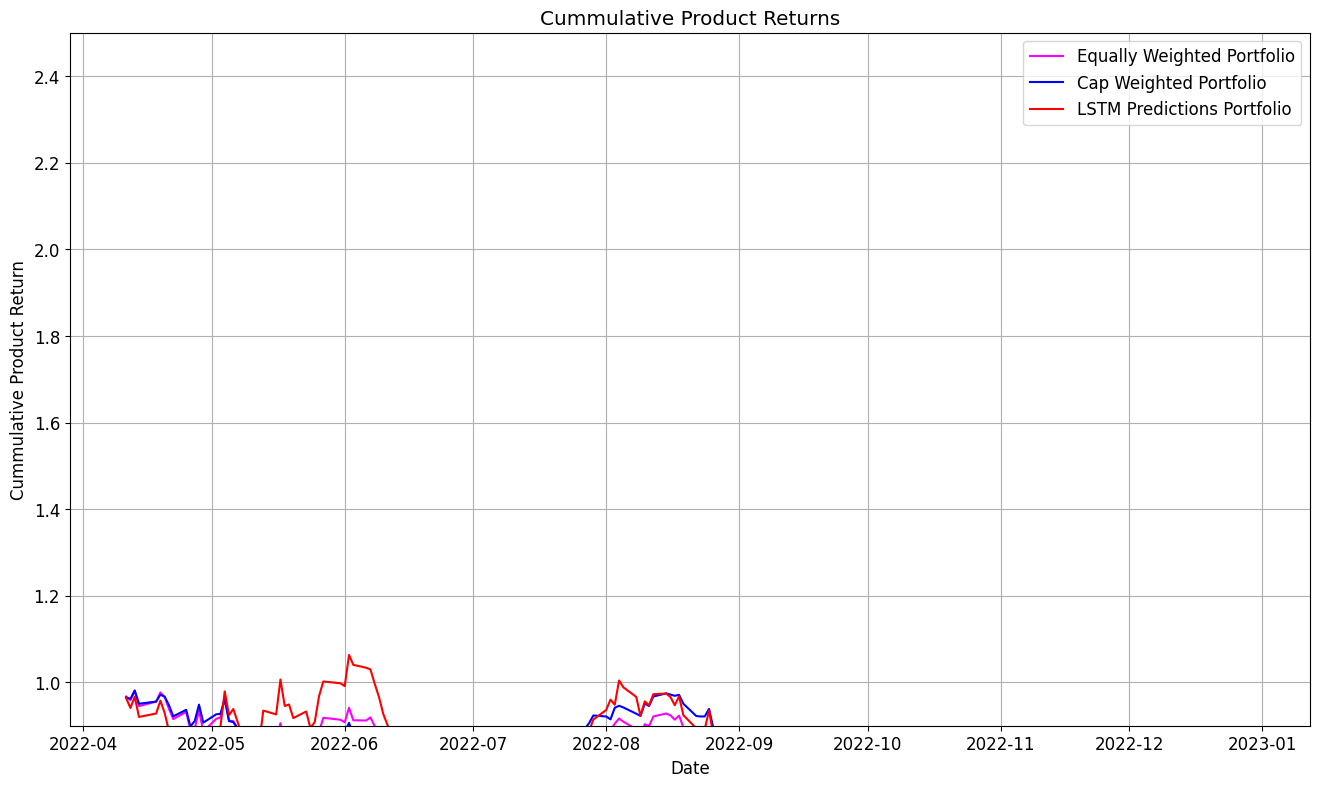

In [118]:
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Eq Cum Prod Return'],
         label='Equally Weighted Portfolio', color='fuchsia')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Cap Cum Prod Return'],
         label='Cap Weighted Portfolio', color='blue')
plt.plot(act_daily_port_ret_df.index, act_daily_port_ret_df['Pred Cum Prod Return'],
         label='LSTM Predictions Portfolio', color='red')
plt.xlabel('Date')
plt.ylabel('Cummulative Product Return')
plt.title('Cummulative Product Returns')
plt.ylim(0.9, 2.5)
plt.legend()
plt.show()

The provided line plot shows the cumulative product returns over time for three different portfolios: an equally weighted portfolio (Equally Weighted Portfolio), a market capitalization-weighted portfolio (Cap Weighted Portfolio), and a portfolio based on LSTM predictions (LSTM Predictions Portfolio). Here's a general analysis based on the plot:

__Equally Weighted Portfolio (Fuchsia Line):__

The fuchsia line represents an equally weighted portfolio, where each asset in the portfolio is given an equal weight.
The cumulative product return steadily increases over time, indicating positive performance.

__Cap Weighted Portfolio (Blue Line):__

The blue line represents a market capitalization-weighted portfolio, where assets are weighted based on their market capitalization.
The cumulative product return also shows a positive trend, with potential fluctuations.

__LSTM Predictions Portfolio (Red Line):__

The red line represents a portfolio based on LSTM predictions, where the weights are determined using predictions from a Long Short-Term Memory (LSTM) model.
The cumulative product return for this portfolio exhibits more variability compared to the equally weighted and cap-weighted portfolios.




## 9. Conclusion:

All three portfolios show an increasing trend in cumulative product returns over time, suggesting overall positive performance during the analyzed period.

The LSTM Predictions Portfolio appears to have higher volatility, with periods of both rapid growth and decline.

The Equally Weighted and Cap Weighted Portfolios exhibit smoother trends, indicating more stable performance.

The analysis is based on cumulative product returns, which consider the compounding effect of returns over time.

The specific time frame, market conditions, and the quality of predictions from the LSTM model can significantly impact the observed trends.

Investors may consider the trade-off between stability and potential higher returns when choosing a portfolio strategy. The LSTM Predictions Portfolio, while potentially offering higher returns, comes with increased volatility and risk.
It's essential to conduct a more in-depth analysis, including risk assessment, statistical measures, and consideration of external factors, to make informed decisions about the performance and suitability of each portfolio strategy.


In [8]:
import io
import nbformat
import glob

# Get a list of all ipynb files in the current directory
nbfile = glob.glob('Project Report.ipynb')

# Check if there is at least one ipynb file
if len(nbfile) > 0:
    with io.open(nbfile[0], 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, nbformat.NO_CONVERT)
    word_count = 0
    for cell in nb.cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print('Word count for file', nbfile[0], 'is', word_count)
else:
    print('No ipynb files found with the specified name.')


Word count for file Investment_Portfolio_Optimization_final.ipynb is 6123


## References:

1. https://github.com/Alejandro-Duenas/deep-learning-portfolio
2. https://www.udacity.com/course/machine-learning-for-trading--ud501
3. https://github.com/ranaroussi/yfinance
4. https://finance.yahoo.com/